In [507]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import ks_2samp, gaussian_kde
from scipy.stats import ttest_ind
from statsmodels.distributions.empirical_distribution import ECDF

# Add the parent directory of current directory to the Python path
sys.path.insert(0, os.path.abspath('..'))

from src.utils.process_session import *
from src.utils.optostim import *

### metadata and extract some data for writing codes

In [155]:
# metadata
Experiment = "test_data"
Animals = ["SP111", "SP112"]
Group = ["Control", "Control"]
Path_To_Raw_Data = "/home/sthitapati/Documents/sequence_data/bpod_raw_data"
Camera_Folder = "/home/sthitapati/Documents/sequence_data/SP_FlyCap"
Output_Folder = "/home/sthitapati/Documents/sequence_data/output"


In [156]:
current_animal = Animals[1]
# print(current_animal)

all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
print(all_sessions_file_name)


/home/sthitapati/Documents/sequence_data/output/SP112/SP112_transition_data_all_sessions.csv


In [157]:
allsessions_DF = pd.read_csv(all_sessions_file_name)
allsessions_DF.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
0,0,1,22,2,2,122.5270,122.5454,123.8857,123.9791,1.3403,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
1,1,1,22,2,2,123.8857,123.9791,124.0053,124.0335,0.0262,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
2,2,1,22,2,2,124.0053,124.0335,124.0566,124.3226,0.0231,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
3,3,1,22,2,2,124.0566,124.3226,124.3291,124.3915,0.0065,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
4,4,1,21,2,1,124.3291,124.3915,134.7244,134.7446,10.3329,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control


In [158]:
# get session settings

sessions_df = get_session_settings(Output_Folder, current_animal)
sessions_df.head()

,session_id,session,date,file_number,day,opto_session,experiment_type
0,0,00_20230421_115325_Fri,2023-04-21,115325,Fri,False,1_Training
1,1,01_20230422_151343_Sat,2023-04-22,151343,Sat,False,1_Training
2,2,02_20230423_184215_Sun,2023-04-23,184215,Sun,False,1_Training
3,3,03_20230424_135300_Mon,2023-04-24,135300,Mon,False,1_Training
4,4,04_20230425_134800_Tue,2023-04-25,134800,Tue,False,1_Training


In [159]:
# get list of all sessions with opto_stim

opto_session_ids = get_opto_sessions(sessions_df)
print(opto_session_ids)

[36, 37, 38, 39, 40, 41, 42, 43, 45]


In [160]:
# make a dataframe by filtering for opto sessions with allsessions_DF['session_id'] = opto_session_ids

opto_df = allsessions_DF[allsessions_DF['session_id'].isin(opto_session_ids)]
opto_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
118533,0,1,26,2,6,36.2121,36.6108,36.9676,36.9959,0.3568,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118534,1,1,66,6,6,36.9676,36.9959,37.0260,37.2329,0.0301,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118535,2,1,66,6,6,37.0260,37.2329,37.2395,37.2459,0.0066,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118536,3,1,63,6,3,37.2395,37.2459,37.6719,37.7833,0.4260,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118537,4,1,37,3,7,37.6719,37.7833,38.0772,38.3069,0.2939,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control


In [161]:
# info

# opto_df.info()

In [162]:
# Count the occurrences of each unique value in 'opto_condition'
opto_condition_counts = opto_df['opto_condition'].value_counts()
print('summary of opto-transitions \n', opto_condition_counts)

# Count the occurrences of each unique value in 'opto_stimulated_port'
opto_stimulated_port_counts = opto_df['opto_stimulated_port'].value_counts()
print('specific ports \n', opto_stimulated_port_counts)

summary of opto-transitions 
 1.0    3960
Name: opto_condition, dtype: int64
specific ports 
 2.0    1050
1.0    1000
4.0     965
3.0     945
Name: opto_stimulated_port, dtype: int64


In [163]:
# count number of control trials
# nan_counts_opto_condition = opto_df['opto_condition'].isna().sum()
# print('opto_stim', nan_counts_opto_condition)

nan_counts_opto_stimulated_port = opto_df['opto_stimulated_port'].isna().sum()
print('all_ports', nan_counts_opto_stimulated_port)

all_ports 28521


In [164]:
# now just look at control data and develop plotting functionality

control_df = opto_df[opto_df['opto_condition'].isna()]
control_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
118541,8,2,16,1,6,39.6320,39.6880,40.2369,40.3083,0.5489,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118542,9,2,63,6,3,40.2369,40.3083,40.6669,41.0318,0.3586,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118543,10,2,37,3,7,40.6669,41.0318,41.3113,41.4741,0.2795,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118544,11,2,72,7,2,41.3113,41.4741,42.2490,42.4246,0.7749,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118545,12,2,21,2,1,42.2490,42.4246,42.7294,42.7822,0.3048,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control


In [165]:
# control_df.info()

In [166]:
control_df.groupby(['end_poke_port', 'start_poke_port']).size().unstack()

start_poke_port,1,2,3,4,5,6,7,8
end_poke_port,,,,,,,,
1,1790.0,3495.0,75.0,6.0,3.0,283.0,287.0,NaN
2,436.0,803.0,216.0,3.0,10.0,443.0,3428.0,2.0
3,366.0,282.0,1043.0,14.0,5.0,3744.0,511.0,5.0
4,4.0,4.0,3.0,1.0,1.0,4.0,7.0,3.0
5,19.0,8.0,NaN,1.0,12.0,3.0,1.0,NaN
6,3332.0,554.0,585.0,NaN,12.0,1603.0,256.0,1.0
7,21.0,49.0,4100.0,NaN,NaN,312.0,349.0,4.0
8,NaN,NaN,1.0,3.0,NaN,2.0,9.0,7.0


In [167]:
# Create mapping from old port numbers to new names
port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5'}

# If there are other ports not included in the correct sequence, map them to X, Y, Z
# Note: replace 4, 5, 8 with actual port numbers if different
port_mapping.update({4: 'port X', 5: 'port Y', 8: 'port Z'})

In [168]:
def plot_transition_matrix(df, normalize=False, display_numbers=False, additional_title=None, ax=None, colorbar=True):
    # Create a copy of df
    df_copy = df.copy()

    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by end and start port and count the number of each transition
    transition_counts = df_copy.groupby(['end_poke_port', 'start_poke_port']).size().unstack(fill_value=0)

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)

    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values)

    if normalize:
        # Normalize columns to get transition probabilities
        column_sums = transition_counts.sum(axis=0, keepdims=True)
        column_sums[column_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / column_sums
        # print("Column sums after normalization:", transition_counts.sum(axis=0))  # Debug line to check the column sums ## for debugging
        colorbar_label = 'Transition Probabilities'
        title = 'State Transition Matrix'

    else:
        colorbar_label = 'Number of Transitions'
        title = 'Absolute Transition Matrix'

    # Add the additional title if specified by the user
    if additional_title:
        title = title + '\n' + additional_title

    # If no Axes object was provided, create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Plotting transition matrix, only select first 4 columns (Start Ports 1 to 4)
    cax = sns.heatmap(transition_counts[:,:4], annot=display_numbers, cmap='YlGnBu', vmin=0, vmax=0.9, ax=ax,
                      xticklabels=ordered_ports[:4], yticklabels=ordered_ports[::-1], cbar=colorbar)
    ax.set_title(title)
    ax.set_xlabel('Start Port')
    ax.set_ylabel('End Port')
    ax.set_aspect('equal')  # set aspect ratio
    # Add a horizontal line in between rows of port 5 and port X
    ax.axhline(y=3, color='k', linewidth=1)

    # Add a colorbar with label
    if colorbar:
        cbar = cax.collections[0].colorbar
        cbar.set_label(colorbar_label)

    # Save the figure
    save_path = os.path.join(Output_Folder, current_animal, 'plots', f'{additional_title}_heatmap.png')

    # Ensure the directory exists
    os.makedirs(os.path.join(Output_Folder, current_animal, 'plots'), exist_ok=True)

    plt.tight_layout()
   
    if ax is None:
        plt.show()  # Only show the plot if no Axes object was provided. If an Axes was provided, plt.show() should be called externally.


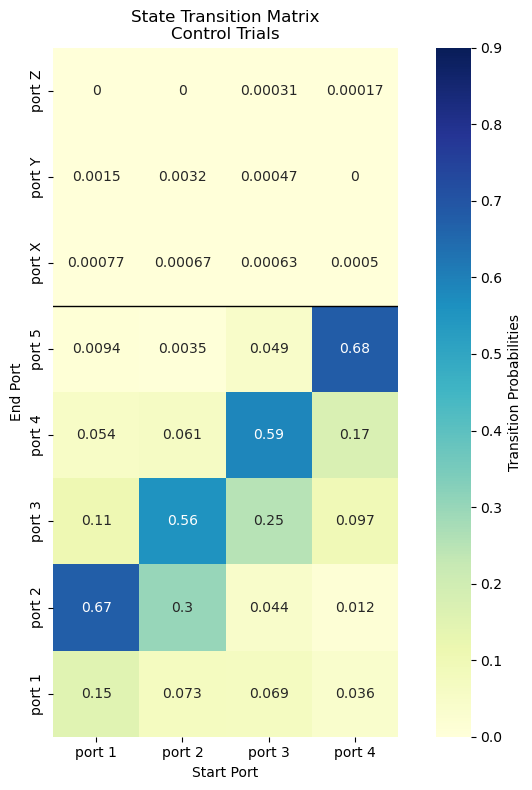

In [169]:

plot_transition_matrix(control_df, normalize=True, display_numbers=True, additional_title= 'Control Trials')
plt.show()

In [170]:
# set colorbar value range 0-0.9
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 0.9])
optostim_port_1 = opto_df[opto_df['opto_stimulated_port'] == 1]
optostim_port_2 = opto_df[opto_df['opto_stimulated_port'] == 2]
optostim_port_3 = opto_df[opto_df['opto_stimulated_port'] == 3]
optostim_port_4 = opto_df[opto_df['opto_stimulated_port'] == 4]


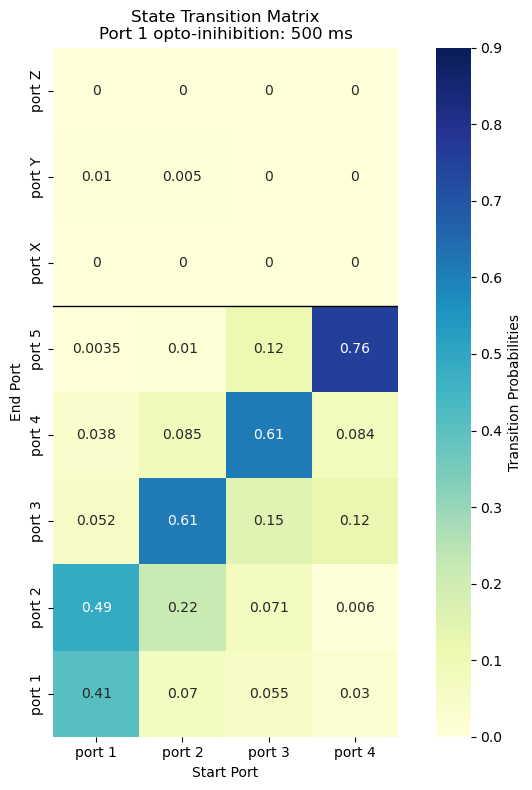

In [171]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, additional_title= 'Port 1 opto-inihibition: 500 ms', ax=ax)


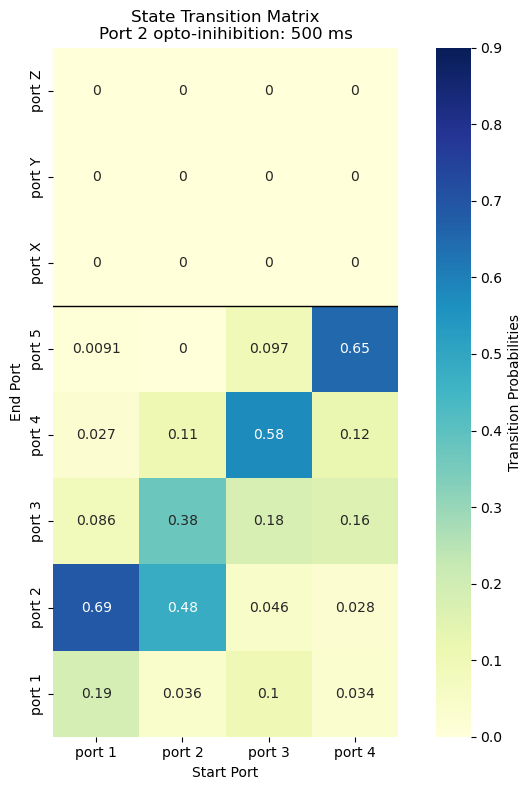

In [172]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, additional_title= 'Port 2 opto-inihibition: 500 ms', ax=ax)

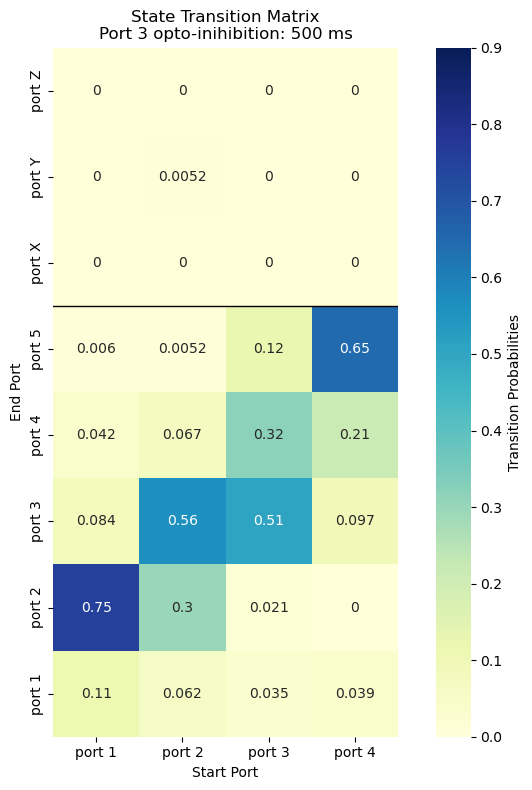

In [173]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, additional_title= 'Port 3 opto-inihibition: 500 ms', ax=ax)

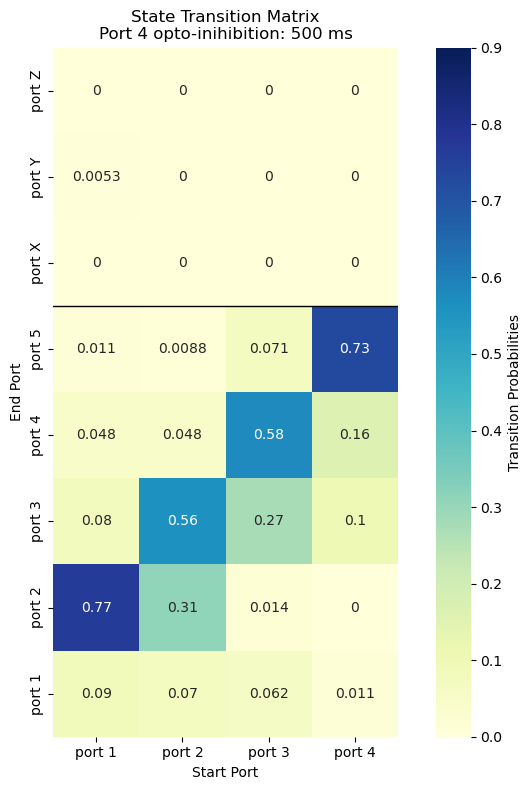

In [174]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, additional_title= 'Port 4 opto-inihibition: 500 ms', ax=ax)

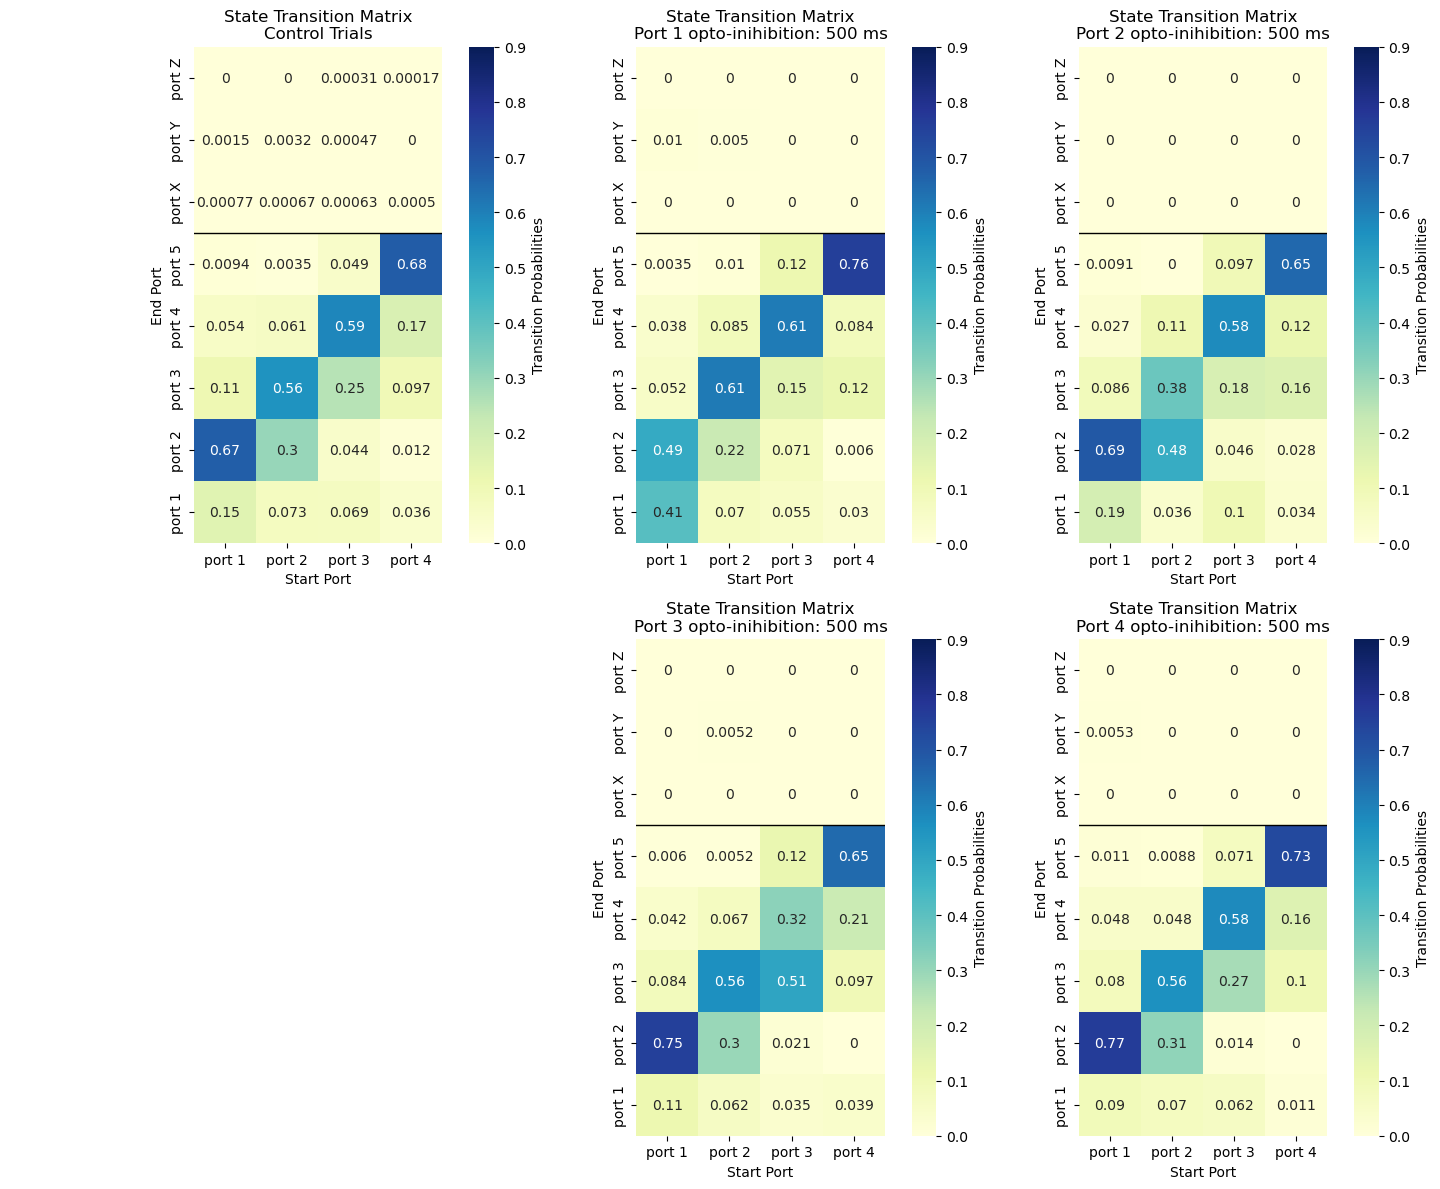

In [175]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_transition_matrix(control_df, normalize=True, display_numbers=True, additional_title= 'Control Trials', ax=axs[0, 0])
plot_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, additional_title= 'Port 1 opto-inihibition: 500 ms', ax=axs[0, 1])
plot_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, additional_title= 'Port 2 opto-inihibition: 500 ms', ax=axs[0, 2])
plot_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, additional_title= 'Port 3 opto-inihibition: 500 ms', ax=axs[1, 1])
plot_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, additional_title= 'Port 4 opto-inihibition: 500 ms', ax=axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.2) # You can adjust this value as needed
plt.show()


In [176]:
# control_df.head()

In [177]:
def compute_transition_matrix(df, normalize=False):
    # Create a copy of df
    df_copy = df.copy()
    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by end and start port and count the number of each transition
    transition_counts = df_copy.groupby(['end_poke_port', 'start_poke_port']).size().unstack(fill_value=0)
    print('NOTE: column is start ports, row is end ports: \n so make sure to transpose if needed as algorithms may look at row entry as start port')

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)

    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values.astype(float))

    if normalize:
        # Normalize columns to get transition probabilities
        column_sums = transition_counts.sum(axis=0, keepdims=True)
        column_sums[column_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / column_sums

    # Convert back to DataFrame
    transition_counts = pd.DataFrame(transition_counts, index=ordered_ports[::-1], columns=ordered_ports)
    return transition_counts



In [178]:
# plot transition matrix

transition_matrix = compute_transition_matrix(control_df, normalize=True)
transition_matrix
# type(transition_matrix)
# Sum across columns (i.e., sum all values in each column)
# column_sums = transition_matrix.sum(axis=0)

# # Print the result
# print("Sum of each column:\n", column_sums)

NOTE: column is start ports, row is end ports: 
 so make sure to transpose if needed as algorithms may look at row entry as start port


,port 1,port 2,port 3,port 4,port 5,port X,port Y,port Z
port Z,0.000000,0.000000,0.000313,0.000166,0.001856,0.107143,0.000000,0.318182
port Y,0.001540,0.003184,0.000469,0.000000,0.000206,0.035714,0.279070,0.000000
port X,0.000770,0.000670,0.000626,0.000498,0.001444,0.035714,0.023256,0.136364
port 5,0.009432,0.003519,0.048796,0.680724,0.071988,0.000000,0.000000,0.181818
port 4,0.054283,0.061327,0.585549,0.173170,0.105404,0.500000,0.116279,0.227273
port 3,0.106641,0.558311,0.250704,0.097128,0.052805,0.000000,0.279070,0.045455
port 2,0.672762,0.299933,0.044260,0.012452,0.059200,0.214286,0.069767,0.000000
port 1,0.154572,0.073056,0.069284,0.035863,0.707096,0.107143,0.232558,0.090909


In [179]:
# copy_df = trial_df.copy().reset_index()
# copy_df['2s_time_filter_out_in'].iloc[4] = 0
# copy_df['2s_time_filter_out_in']

# split trial_df into trial_df_1, trial_df_2, at rows where 2s_time_filter_out_in is False

def split_dataframe(df, column):
    """
    Splits the given DataFrame into multiple DataFrames based on the specified column.
    The DataFrame is split whenever the specified column has a False value.

    Args:
    df (pandas.DataFrame): The DataFrame to be split.
    column (str): The name of the column based on which the DataFrame will be split.

    Returns:
    list: A list containing the resulting DataFrames.
    """

    # Initialize an empty list to store the resulting DataFrames
    df_list = []

    # Initialize an empty DataFrame for the first segment
    df_segment = pd.DataFrame()

    # Iterate over the rows of the input DataFrame
    for index, row in df.iterrows():

        # If the current row in the specified column is True, 
        # add the row to the current segment
        if row[column]:
            df_segment = pd.concat([df_segment, pd.DataFrame(row).T])
        # If the current row in the specified column is False,
        # append the current segment to df_list and start a new segment
        else:
            df_list.append(df_segment)
            df_segment = pd.DataFrame()
            df_segment = pd.concat([df_segment, pd.DataFrame(row).T])

    # If the last segment is not empty, append it to df_list
    if not df_segment.empty:
        df_list.append(df_segment)

    # Return the list of DataFrames
    return df_list

# df_list = split_dataframe(copy_df, '2s_time_filter_out_in')



In [180]:
def generate_transition_lists():
    """
    Generate lists of correct, error, and neutral transitions. 

    Correct transitions follow the sequence 2 -> 1 -> 6 -> 3 -> 7 -> 2, 
    Neutral transitions are those where the start and end ports are the same or transitions to irrelevant ports [4, 5, 8],
    Error transitions are all others.
    
    Returns:
    correct_transitions (list): List of correct transitions.
    error_transitions (list): List of error transitions.
    neutral_transitions (list): List of neutral transitions.
    """

    # Generate all possible transitions from 1-8 to 1-8
    all_transitions = [10*i + j for i in range(1, 9) for j in range(1, 9)]

    # Define the correct sequence
    correct_sequence = [2, 1, 6, 3, 7, 2]

    # Generate correct transitions based on the correct sequence
    correct_transitions = [10*correct_sequence[i] + correct_sequence[i+1] for i in range(len(correct_sequence)-1)]
    # The sequence wraps around, so manually add the last transition to complete the cycle
    correct_transitions.append(72)

    # Generate neutral transitions
    # Neutral transitions start and end at the same port
    same_port_transitions = [11*i for i in range(1, 9)]
    # Neutral transitions also include transitions to irrelevant ports (4, 5, 8)
    irrelevant_port_transitions = [10*i + j for i in [4, 5, 8] for j in range(1, 9)]
    neutral_transitions = same_port_transitions + irrelevant_port_transitions

    # Generate error transitions
    # Error transitions are all others that are not correct or neutral
    error_transitions = list(set(all_transitions) - set(correct_transitions) - set(neutral_transitions))

    return correct_transitions, error_transitions, neutral_transitions

# Call the function to get the transition lists
correct_transitions, error_transitions, neutral_transitions = generate_transition_lists()


def get_repeat_transitions(df):
    """
    Creates a new column 'is_repeat' to indicate if the transition is a repeat.
    A repeat transition is defined as a transition where the start and end ports are the same.

    Args:
    df (pandas.DataFrame): The DataFrame with the transitions data. 
                           The DataFrame should have 'start_poke_port' and 'end_poke_port' columns.

    Returns:
    pandas.Series: A Series with True for repeat transitions and False for others.
    """
    return df['start_poke_port'] == df['end_poke_port']


def get_transition_labels(df):
    """
    Creates a new column 'transition_label' to classify the transition.
    Transitions are classified as 'correct', 'neutral', or 'error' based on predefined lists.
    'correct' transitions are those where 'transition_type' is in the correct_transitions list.
    'neutral' transitions are those where 'transition_type' is in the neutral_transitions list.
    'error' transitions are those where 'transition_type' is in the error_transitions list.

    Args:
    df (pandas.DataFrame): The DataFrame with the transitions data.
                           The DataFrame should have 'transition_type' column.

    Returns:
    pandas.Series: A Series with the transition classification.
    """
    correct_transitions = [21,16,63,37,72]
    error_transitions = [23,24,25,26,27,28,12,13,14,15,17,18,61,62,64,65,67,68,31,32,34,35,36,38]
    neutral_transitions = [11,22,33,66,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,71,73,74,75,76,77,78,81,82,83,84,85,86,87,88]

    transition_labels = pd.Series(['error'] * len(df), index=df.index)

    mask_correct = df['transition_type'].isin(correct_transitions)
    transition_labels[mask_correct] = 'correct'

    mask_neutral = df['transition_type'].isin(neutral_transitions)
    transition_labels[mask_neutral] = 'neutral'

    return transition_labels

In [181]:
# create the sequence performend by the mouse in the chosen trial

perfect_sequence = '21637'
start_port = perfect_sequence[0]

def get_sequence_info(df):
    """
    This function extracts the start poke port from the dataframe and returns it as a string, 
    and the in-in latency as a list of numerical values.

    Args:
    df (pandas.DataFrame): The DataFrame with the transitions data. 
                           The DataFrame should have 'start_poke_port' and 'in_in_latency' columns.

    Returns:
    str, list: The first output is a string that contains the 'start_poke_port' values 
               and the second output is a list that contains the 'in_in_latency' numerical values.
    """
    # Convert 'start_poke_port' to string and join all elements into a single string
    start_poke_ports = ''.join(map(str, df['start_poke_port'].tolist()))

    # convert 'end_poke_port' to string and join all elements into a single string
    end_poke_ports = ''.join(map(str, df['end_poke_port'].tolist()))
    
    # Keep 'in_in_latency' as a list of floats
    in_in_latencies = df['in_in_latency'].tolist()

    # Keep 'out_in_latency' as a list of floats
    out_in_latencies = df['out_in_latency'].tolist()

    return start_poke_ports, end_poke_ports, in_in_latencies, out_in_latencies

In [182]:
def compute_levenshtein_distance(test_sequence, target_sequence='21637', start_port='2'):
    """
    Compute the Levenshtein distance between the test sequence and the target sequence.

    The Levenshtein distance is the minimum number of single-character edits 
    (insertions, deletions or substitutions) required to change one sequence into the other.

    Parameters:
    test_sequence (str): The sequence to compare against the target. 
                         This sequence should be a string representation of poke ports.
    target_sequence (str): The target sequence. This is the sequence to which we are comparing 
                           the test sequence. Default is '21637'.
    start_port (str): The poke port number at which the sequence starts, represented as a string. Default is '2'.

    Returns:
    float: The Levenshtein distance between the test sequence and the target sequence.
    """

    # Disregard anything before the first occurrence of start_port in the test sequence
    test_sequence = test_sequence[test_sequence.index(start_port):] if start_port in test_sequence else test_sequence

    size_x = len(test_sequence) + 1
    size_y = len(target_sequence) + 1
    matrix = np.zeros((size_x, size_y))

    # Initialize the first row and first column
    matrix[:, 0] = range(size_x)
    matrix[0, :] = range(size_y)

    # Compute the rest of the matrix
    for x in range(1, size_x):
        for y in range(1, size_y):
            if test_sequence[x - 1] == target_sequence[y - 1]:
                matrix[x, y] = min(
                    matrix[x - 1, y] + 1,     # Deletion
                    matrix[x - 1, y - 1],     # Substitution
                    matrix[x, y - 1] + 1      # Insertion
                )
            else:
                matrix[x, y] = min(
                    matrix[x - 1, y] + 1,     # Deletion
                    matrix[x - 1, y - 1] + 1, # Substitution
                    matrix[x, y - 1] + 1      # Insertion
                )

    # The final Levenshtein distance is the value in the bottom right corner of the matrix
    return matrix[size_x - 1, size_y - 1]



# print(compute_levenshtein_distance(start_poke_ports, perfect_sequence, start_port))


Edit distance statistics:
Mean distance: 2.280806979280262
Median distance: 1.0
Min distance: 0.0
Max distance: 20.0
Standard deviation of distances: 2.9228898106099805


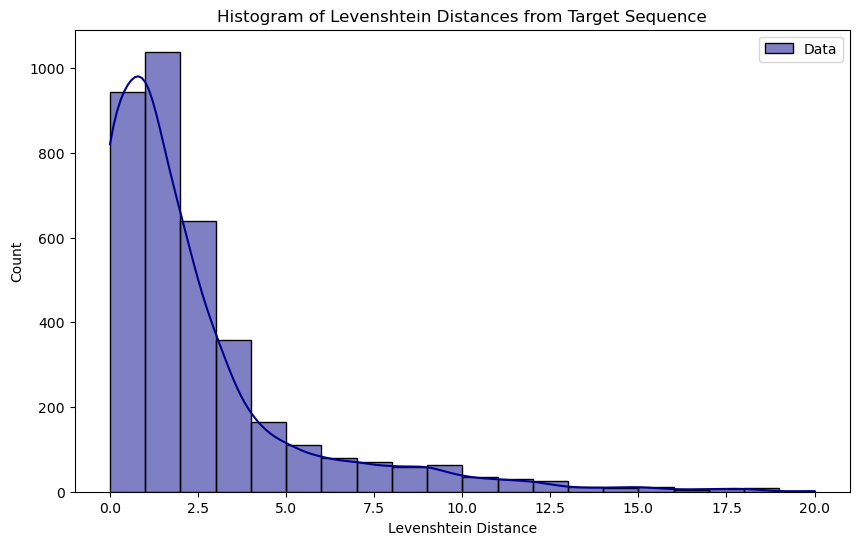

In [183]:
def get_edit_distance_statistics(df, max_edit_distance=20):
    """
    Calculate Levenshtein distances for sequences in a DataFrame and return edit distance statistics.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data for analysis.
            It should have a column 'cumulative_trial_id' representing the trial IDs.

    Returns:
        dict: A dictionary containing statistics and the distances array.
            The dictionary has the following keys:
                - 'mean_distance': The mean Levenshtein distance.
                - 'median_distance': The median Levenshtein distance.
                - 'min_distance': The minimum Levenshtein distance.
                - 'max_distance': The maximum Levenshtein distance.
                - 'std_distance': The standard deviation of Levenshtein distances.
                - 'distances_array': A numpy array containing all the Levenshtein distances.
    """
    # Get all unique cumulative_trial_ids from the DataFrame and sort them
    unique_trial_ids = df['cumulative_trial_id'].unique()
    unique_trial_ids.sort()

    # Create a list to store all sequences
    sequences = []

    # Loop over all unique cumulative_trial_ids and compute the sequences
    for id in unique_trial_ids:
        # Filter the DataFrame for the specific id
        filtered_df = df[df['cumulative_trial_id'] == id].reset_index(drop=True)
        # Get the start poke ports and in_in_latencies sequences for this trial_id
        start_poke_ports, _, _, _ = get_sequence_info(filtered_df)  # Define this function separately
        # Append the sequence to the list as a concatenated string
        sequences.append(''.join(str(p) for p in start_poke_ports))

    # Now we have a list of all sequences and we can compute the Levenshtein distance for all pairs of sequences
    # Create a list to store all Levenshtein distances
    distances = []

    # Loop over each sequence to compute Levenshtein distance
    for sequence in sequences:
        # Compute the Levenshtein distance between the sequence and the target_sequence (target_sequence is not defined in the code)
        distance = compute_levenshtein_distance(sequence)  # Define this function separately
        distances.append(distance)

    # Convert the list to a numpy array for easier calculations
    distance_array = np.array(distances)

    # Discard sequences with an edit distance greater than max_edit_distance
    distance_array = distance_array[distance_array <= max_edit_distance]

    # Calculate statistics
    mean_distance = np.mean(distance_array)
    median_distance = np.median(distance_array)
    min_distance = np.min(distance_array)
    max_distance = np.max(distance_array)
    std_distance = np.std(distance_array)

    # Create the result dictionary
    edit_statistics = {
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'min_distance': min_distance,
        'max_distance': max_distance,
        'std_distance': std_distance,
        'distances_array': distance_array
    }

    return edit_statistics

optostim_port_1 = opto_df[opto_df['opto_stimulated_port'] == 1]
optostim_port_2 = opto_df[opto_df['opto_stimulated_port'] == 2]
optostim_port_3 = opto_df[opto_df['opto_stimulated_port'] == 3]
optostim_port_4 = opto_df[opto_df['opto_stimulated_port'] == 4]

edit_statistics = get_edit_distance_statistics(control_df)

# Print the statistics for the DataFrame
print("Edit distance statistics:")
print(f"Mean distance: {edit_statistics['mean_distance']}")
print(f"Median distance: {edit_statistics['median_distance']}")
print(f"Min distance: {edit_statistics['min_distance']}")
print(f"Max distance: {edit_statistics['max_distance']}")
print(f"Standard deviation of distances: {edit_statistics['std_distance']}")

# Now, plot the histogram of distances
plt.figure(figsize=(10, 6))
sns.histplot(edit_statistics['distances_array'], bins=20, kde=True, color='darkblue', label='Data')
plt.title("Histogram of Levenshtein Distances from Target Sequence")
plt.xlabel("Levenshtein Distance")
plt.ylabel("Count")
plt.legend()
plt.show()


In [184]:
def plot_edit_distance_histograms(edit_statistics_list, labels, control_bins=50, other_bins=5):
    """
    Plot histograms of Levenshtein distances for multiple DataFrames.

    Parameters:
        edit_statistics_list (list): A list of edit distance statistics dictionaries for each DataFrame.
            Each dictionary should contain 'distances_array' key.
        labels (list): A list of labels for each DataFrame (e.g., ['Port 1', 'Port 2', ...]).
        control_bins (int): Number of bins for the 'control' DataFrame.
        other_bins (int): Number of bins for other DataFrames.
    """
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set1", n_colors=len(edit_statistics_list))

    for idx, stats in enumerate(edit_statistics_list):
        distances_array = stats['distances_array']
        if labels[idx] == 'control':
            bins = control_bins
        else:
            bins = other_bins
        sns.kdeplot(data=distances_array, color=colors[idx], label=labels[idx])
        
        # Create a Gaussian kernel density estimate
        kde = gaussian_kde(distances_array)

        # Generate points for the x axis
        x_points = np.linspace(distances_array.min(), distances_array.max(), 500)

        # Evaluate the KDE on these points
        densities = kde.evaluate(x_points)

        # Find the x value that corresponds to the peak of the density
        peak_density_x = x_points[np.argmax(densities)]

        # Plot a vertical line at the peak
        plt.axvline(peak_density_x, color=colors[idx], linestyle='--', alpha=0.5)
     
    plt.title("Histogram of Levenshtein Distances from Target Sequence")
    plt.xlabel("Levenshtein Distance")
    plt.ylabel("Density")
    plt.legend()
    sns.despine()
    plt.gca().set_aspect('auto')

    # Find the first 99 percentile of the data and set xlim accordingly
    percentile_99 = np.percentile(np.concatenate([stats['distances_array'] for stats in edit_statistics_list]), 99)
    plt.xlim(0, percentile_99)

    # Switch off the grid
    plt.grid(False)

    plt.show()




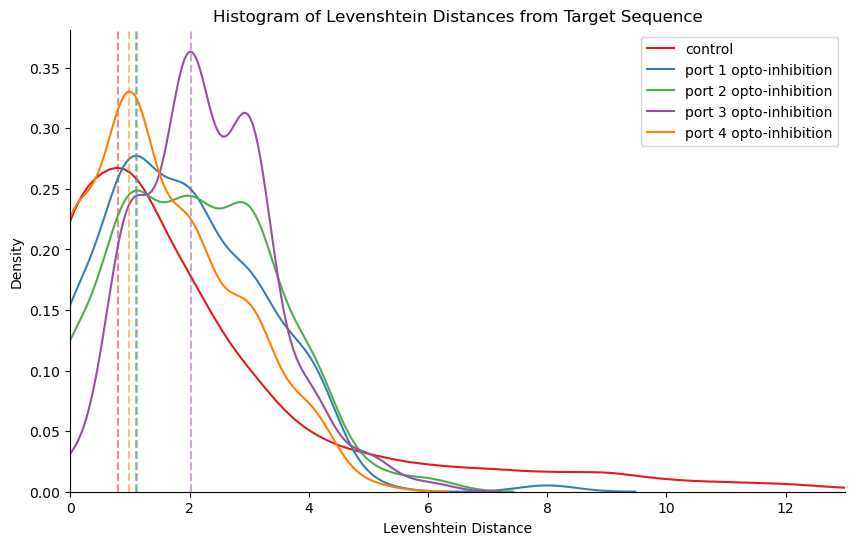

In [185]:
# Calculate edit statistics for each DataFrame
edit_statistics_control = get_edit_distance_statistics(control_df)
edit_statistics_port_1_opto = get_edit_distance_statistics(optostim_port_1)
edit_statistics_port_2_opto = get_edit_distance_statistics(optostim_port_2)
edit_statistics_port_3_opto = get_edit_distance_statistics(optostim_port_3)
edit_statistics_port_4_opto = get_edit_distance_statistics(optostim_port_4)

# Create a list of edit statistics and port labels
edit_statistics_list = [edit_statistics_control, edit_statistics_port_1_opto, edit_statistics_port_2_opto, edit_statistics_port_3_opto, edit_statistics_port_4_opto]
labels = ['control', 'port 1 opto-inhibition', 'port 2 opto-inhibition', 'port 3 opto-inhibition', 'port 4 opto-inhibition']

# Plot the histograms for all DataFrames in the same plot
plot_edit_distance_histograms(edit_statistics_list, labels)



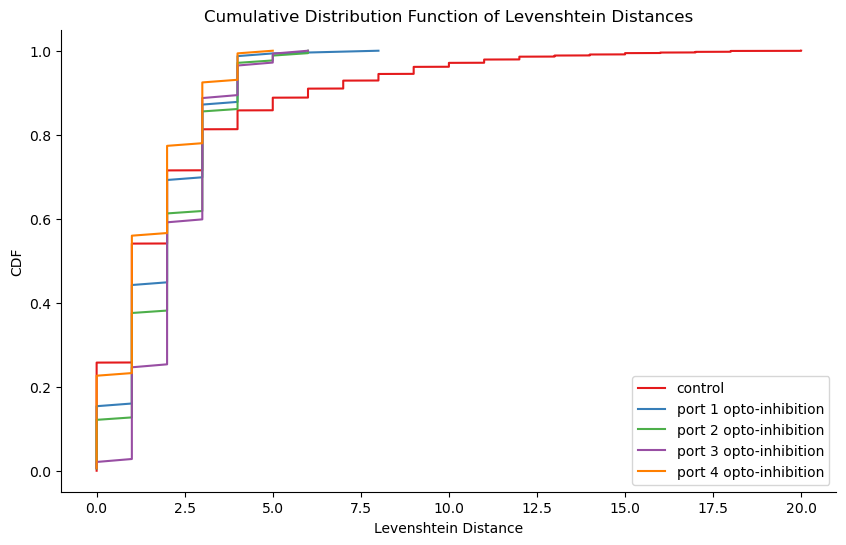

K-S statistic between control and port 1 opto-inhibition: 0.13
P-value: 0.01
K-S statistic between control and port 2 opto-inhibition: 0.17
P-value: 0.00
K-S statistic between control and port 3 opto-inhibition: 0.29
P-value: 0.00
K-S statistic between control and port 4 opto-inhibition: 0.14
P-value: 0.01
K-S statistic between port 1 opto-inhibition and port 2 opto-inhibition: 0.08
P-value: 0.64
K-S statistic between port 1 opto-inhibition and port 3 opto-inhibition: 0.20
P-value: 0.01
K-S statistic between port 1 opto-inhibition and port 4 opto-inhibition: 0.12
P-value: 0.20
K-S statistic between port 2 opto-inhibition and port 3 opto-inhibition: 0.13
P-value: 0.13
K-S statistic between port 2 opto-inhibition and port 4 opto-inhibition: 0.18
P-value: 0.01
K-S statistic between port 3 opto-inhibition and port 4 opto-inhibition: 0.31
P-value: 0.00


In [186]:
def plot_cdfs_and_perform_ks(edit_statistics_list, labels):
    """
    Plot CDFs of Levenshtein distances for multiple DataFrames and perform KS test between each pair of DataFrames.

    Parameters:
        edit_statistics_list (list): A list of edit distance statistics dictionaries for each DataFrame.
            Each dictionary should contain 'distances_array' key.
        labels (list): A list of labels for each DataFrame (e.g., ['Port 1', 'Port 2', ...]).
    """
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set1", n_colors=len(edit_statistics_list))

    for idx, stats in enumerate(edit_statistics_list):
        distances_array = stats['distances_array']
        ecdf = ECDF(distances_array) # Calculate ECDF
        plt.plot(ecdf.x, ecdf.y, color=colors[idx], label=labels[idx])

    plt.title("Cumulative Distribution Function of Levenshtein Distances")
    plt.xlabel("Levenshtein Distance")
    plt.ylabel("CDF")
    plt.legend()
    sns.despine()
    plt.gca().set_aspect('auto')
    plt.show()

    # Perform KS test between each pair of dataframes and print the results
    for i in range(len(edit_statistics_list)):
        for j in range(i + 1, len(edit_statistics_list)):
            ks_stat, p_value = ks_2samp(edit_statistics_list[i]['distances_array'], 
                                        edit_statistics_list[j]['distances_array'])
            print(f"K-S statistic between {labels[i]} and {labels[j]}: {ks_stat:.2f}")
            print(f"P-value: {p_value:.2f}")

# Calculate edit statistics for each DataFrame
edit_statistics_control = get_edit_distance_statistics(control_df)
edit_statistics_port_1_opto = get_edit_distance_statistics(optostim_port_1)
edit_statistics_port_2_opto = get_edit_distance_statistics(optostim_port_2)
edit_statistics_port_3_opto = get_edit_distance_statistics(optostim_port_3)
edit_statistics_port_4_opto = get_edit_distance_statistics(optostim_port_4)

# Create a list of edit statistics and port labels
edit_statistics_list = [edit_statistics_control, edit_statistics_port_1_opto, edit_statistics_port_2_opto, edit_statistics_port_3_opto, edit_statistics_port_4_opto]
labels = ['control', 'port 1 opto-inhibition', 'port 2 opto-inhibition', 'port 3 opto-inhibition', 'port 4 opto-inhibition']

# Plot the CDFs for all DataFrames and perform KS tests
plot_cdfs_and_perform_ks(edit_statistics_list, labels)


### analysis for transition times

In [187]:
# find all sequences from a dataframe arranged according to their cumulative_trial_ids

# get all unique cumulative_trial_ids

cumulative_trial_ids = control_df['cumulative_trial_id'].unique()
cumulative_trial_ids.sort()
# cumulative_trial_ids
# access the dataframe at any cumulative trial id

trial_df = control_df[control_df['cumulative_trial_id'] == cumulative_trial_ids[0]].reset_index(drop=True)
trial_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
0,8,2,16,1,6,39.6320,39.6880,40.2369,40.3083,0.5489,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
1,9,2,63,6,3,40.2369,40.3083,40.6669,41.0318,0.3586,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
2,10,2,37,3,7,40.6669,41.0318,41.3113,41.4741,0.2795,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
3,11,2,72,7,2,41.3113,41.4741,42.2490,42.4246,0.7749,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
4,12,2,21,2,1,42.2490,42.4246,42.7294,42.7822,0.3048,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control


In [188]:
# print(trial_df)

trial_ids = trial_df['trial_id'].values
transition_type = trial_df['transition_type'].values
start_poke_port = trial_df['start_poke_port'].values
end_poke_port = trial_df['end_poke_port'].values
start_poke_in_timestamp = trial_df['start_poke_in_timestamp'].values
start_poke_out_timestamp = trial_df['start_poke_out_timestamp'].values
end_poke_in_timestamp = trial_df['end_poke_in_timestamp'].values
end_poke_out_timestamp = trial_df['end_poke_out_timestamp'].values
in_in_latency = trial_df['in_in_latency'].values
out_in_latency = trial_df['out_in_latency'].values


print('Trial ids', trial_ids)
print('Transitions', transition_type)
print('Start poke port', start_poke_port)
print('End poke port', end_poke_port)
print('Start poke in time stamp', start_poke_in_timestamp)
print('Start poke out time stamp', start_poke_out_timestamp)
print('End poke in time stamp', end_poke_in_timestamp)
print('End poke out time stamp', end_poke_out_timestamp)
print('In-in latency', in_in_latency)
print('Out-in latency', out_in_latency)


Trial ids [2 2 2 2 2 2 2 2 2 2]
Transitions [16 63 37 72 21 11 16 63 37 72]
Start poke port [1 6 3 7 2 1 1 6 3 7]
End poke port [6 3 7 2 1 1 6 3 7 2]
Start poke in time stamp [39.632  40.2369 40.6669 41.3113 42.249  42.7294 42.8806 43.1898 43.5304
 43.8288]
Start poke out time stamp [39.688  40.3083 41.0318 41.4741 42.4246 42.7822 42.8922 43.2895 43.6235
 46.4946]
End poke in time stamp [40.2369 40.6669 41.3113 42.249  42.7294 42.8806 43.1898 43.5304 43.8288
 47.0936]
End poke out time stamp [40.3083 41.0318 41.4741 42.4246 42.7822 42.8922 43.2895 43.6235 46.4946
 47.2131]
In-in latency [0.6049 0.43   0.6444 0.9377 0.4804 0.1512 0.3092 0.3406 0.2984 3.2648]
Out-in latency [0.5489 0.3586 0.2795 0.7749 0.3048 0.0984 0.2976 0.2409 0.2053 0.599 ]


In [189]:
start_poke_ports, end_poke_ports, in_in_latencies, out_in_latencies = get_sequence_info(trial_df)
print('start_poke_ports', start_poke_ports)
print('end_poke_ports', end_poke_ports)
print('in_in_latencies', in_in_latencies)
print('out_in_latencies', out_in_latencies)   
print('perfect sequence', perfect_sequence) 


start_poke_ports 1637211637
end_poke_ports 6372116372
in_in_latencies [0.6049000000000007, 0.4299999999999997, 0.6443999999999974, 0.9376999999999996, 0.480400000000003, 0.1511999999999957, 0.3092000000000041, 0.3405999999999949, 0.2984000000000009, 3.264800000000001]
out_in_latencies [0.5489000000000033, 0.3586000000000027, 0.2794999999999987, 0.7749000000000024, 0.3048000000000002, 0.098399999999998, 0.2976000000000027, 0.2408999999999963, 0.2053000000000011, 0.5990000000000038]
perfect sequence 21637


In [354]:
def filter_dataframe(df, filter_sequence_from_start_port=True):
    """
    This function filters a given dataframe based on specific conditions and returns a new dataframe.

    Parameters:
    df (pandas.DataFrame): Input DataFrame to be filtered.
    filter_sequence_from_start_port (bool): If True, the function filters rows that occur at or after the first occurrence of 2.
        If False, the function sets trial_start_index to the first start_poke_port.

    Returns:
    pandas.DataFrame: The filtered DataFrame.
    """

    # Get all unique cumulative_trial_ids and sort them
    unique_trial_ids = df['cumulative_trial_id'].unique()
    unique_trial_ids.sort()

    # List to store the updated rows
    filtered_rows = []

    for trial_id in unique_trial_ids:
        # Filter DataFrame for specific trial
        trial_df = df[df['cumulative_trial_id'] == trial_id].copy()

        # Find the index of first occurrence based on filter_sequence_from_start_port
        if filter_sequence_from_start_port:
            # Find the index of first occurrence of 2 in start_poke_port
            trial_start_index = trial_df[trial_df['start_poke_port'] == 2].index.min()

            # if pd.isna(trial_start_index):
            #     # If there's no 2 in start_poke_port for the trial, just continue to the next trial
            #     continue
        else:
            # Set trial_start_index to the first start_poke_port
            trial_start_index = trial_df.index.min()

        # Filter rows that occur at or after the trial_start_index
        updated_trial_df = trial_df.loc[trial_start_index:].copy()

        # Set reference timestamp
        reference_timestamp = updated_trial_df.loc[trial_start_index, 'start_poke_in_timestamp']

        # Calculate latency to start trial
        latency_to_start_trial = reference_timestamp - trial_df['start_poke_in_timestamp'].iloc[0]

        # Update timestamp columns and create lists
        for timestamp_column in ['start_poke_in_timestamp', 'start_poke_out_timestamp', 
                                 'end_poke_in_timestamp', 'end_poke_out_timestamp']:
            updated_trial_df[timestamp_column] = list(updated_trial_df[timestamp_column] - reference_timestamp)

        # Calculate new in_in_latency and out_in_latency and create lists
        updated_trial_df['in_in_latency'] = list(updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_in_timestamp'])
        updated_trial_df['out_in_latency'] = list(updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_out_timestamp'])

        # Condense the updated trial DataFrame to one row
        condensed_row = updated_trial_df.iloc[0]
        array_columns = ['transition_type', 'start_poke_port', 'end_poke_port', 
                         'start_poke_in_timestamp', 'start_poke_out_timestamp', 
                         'end_poke_in_timestamp', 'end_poke_out_timestamp', 
                         'out_in_latency', 'in_in_latency', 'repeat_filter', 
                         '2s_time_filter_out_in', '2s_time_filter_in_in', 
                         'opto_condition', 'opto_stimulated_port', 'training_level']
        for column in array_columns:
            condensed_row[column] = np.array(updated_trial_df[column])

        condensed_row['latency_to_start_trial'] = latency_to_start_trial

        # Append condensed row to the filtered DataFrame
        filtered_rows.append(condensed_row)

    # Convert list of rows to DataFrame
    filtered_df = pd.concat(filtered_rows, axis=1).transpose()

    # Reset index of the new DataFrame
    filtered_df.reset_index(drop=True, inplace=True)

    # Drop unnecessary columns
    filtered_df.drop(['led_intensities_ports_2_3_4_5', 'reward_amounts_ports_1_2_3_4'], axis=1, inplace=True)

    return filtered_df

# Usage:
filtered_control_df = filter_dataframe(control_df, filter_sequence_from_start_port=True)


In [355]:
# filtered_control_df.info()

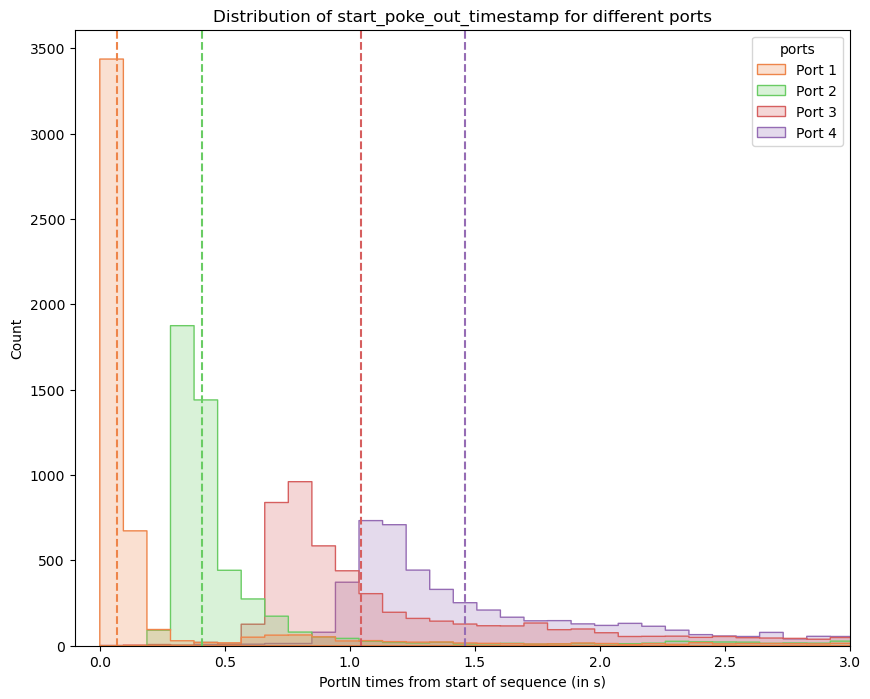

In [356]:
def plot_timestamp_distribution(df, timestamps, x_range=(0, 5), exclude_ports=[], ax=None):
    """
    This function plots the distribution of timestamps for different ports.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains timestamps and port information.
    timestamps (str): The column name in df for the timestamp data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    ax (matplotlib.axes.Axes): Axes object to draw the plot onto.
    """
    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels = {2: 'Port 1', 1: 'Port 2',
                           6: 'Port 3', 3: 'Port 4',
                           7: 'Port 5', 4: 'Other ports',
                           5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, timestamps)):
            if port in port_labels.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[timestamps, 'ports'])

    # If no Axes object provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Use a color palette
    full_palette = sns.color_palette("muted", len(latency_df['ports'].unique()) + 1)  # Added 1 for starting from the second color
    palette_colors = full_palette[1:] 

    # Plot the distribution of timestamps for each ports
    hist_plot = sns.histplot(latency_df, x=timestamps, hue='ports', element="step", stat='count', common_norm=False, palette=palette_colors, ax=ax)

    # Set the limits of x-axis to 'zoom' in
    ax.set_xlim(x_range) 

    # Set the title and labels
    ax.set_title(f'Distribution of {timestamps} for different ports')
    ax.set_xlabel('Transition time (in s)')
    ax.set_ylabel('Count')

    # Add vertical lines at the median value of each distribution
    for port in latency_df['ports'].unique():
        median_latency = latency_df[latency_df['ports'] == port][timestamps].median()
        ax.axvline(median_latency, linestyle='--', color=palette_colors[latency_df['ports'].unique().tolist().index(port)])

    # Check if there are handles and labels for which a legend can be created
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        # Set the title for the legend
        legend = ax.legend()
        if legend.texts:
            legend.texts[0].set_text('Transitions')

    return ax


ax = plot_timestamp_distribution(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8])
ax.set_xlabel('PortIN times from start of sequence (in s)')
plt.show()


In [362]:
# filtered_control_df already exists
filtered_optostim_port_1 = filter_dataframe(optostim_port_1, filter_sequence_from_start_port= True)
filtered_optostim_port_2 = filter_dataframe(optostim_port_2, filter_sequence_from_start_port= True)
filtered_optostim_port_3 = filter_dataframe(optostim_port_3, filter_sequence_from_start_port= True)
filtered_optostim_port_4 = filter_dataframe(optostim_port_4, filter_sequence_from_start_port= True)

### Plot the distribution of port_in_times 

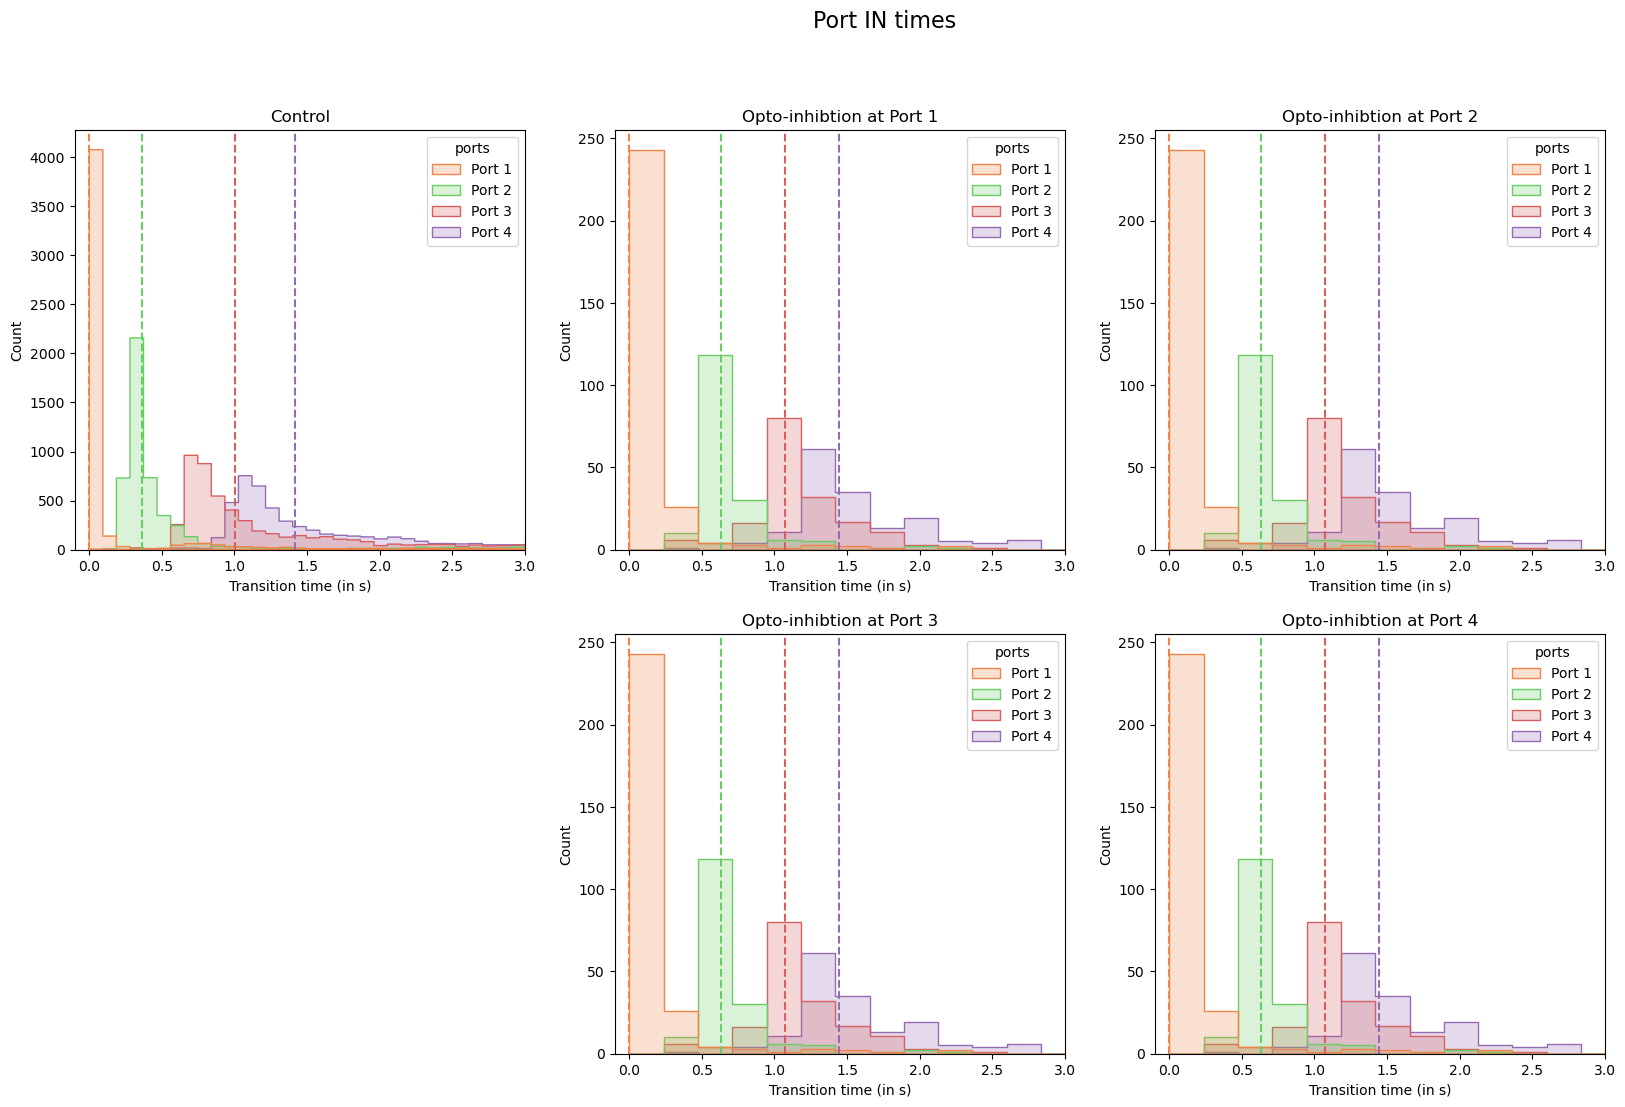

In [377]:
# fetch all opto data

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_distribution(filtered_control_df, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[0, 0])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[0, 1])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax= axs[0, 2])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[1, 1])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# set optional titles
axs[0, 0].set_title('Control')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.05) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port IN times", fontsize=16)
plt.show()

### Plot the distribution of port_out_times

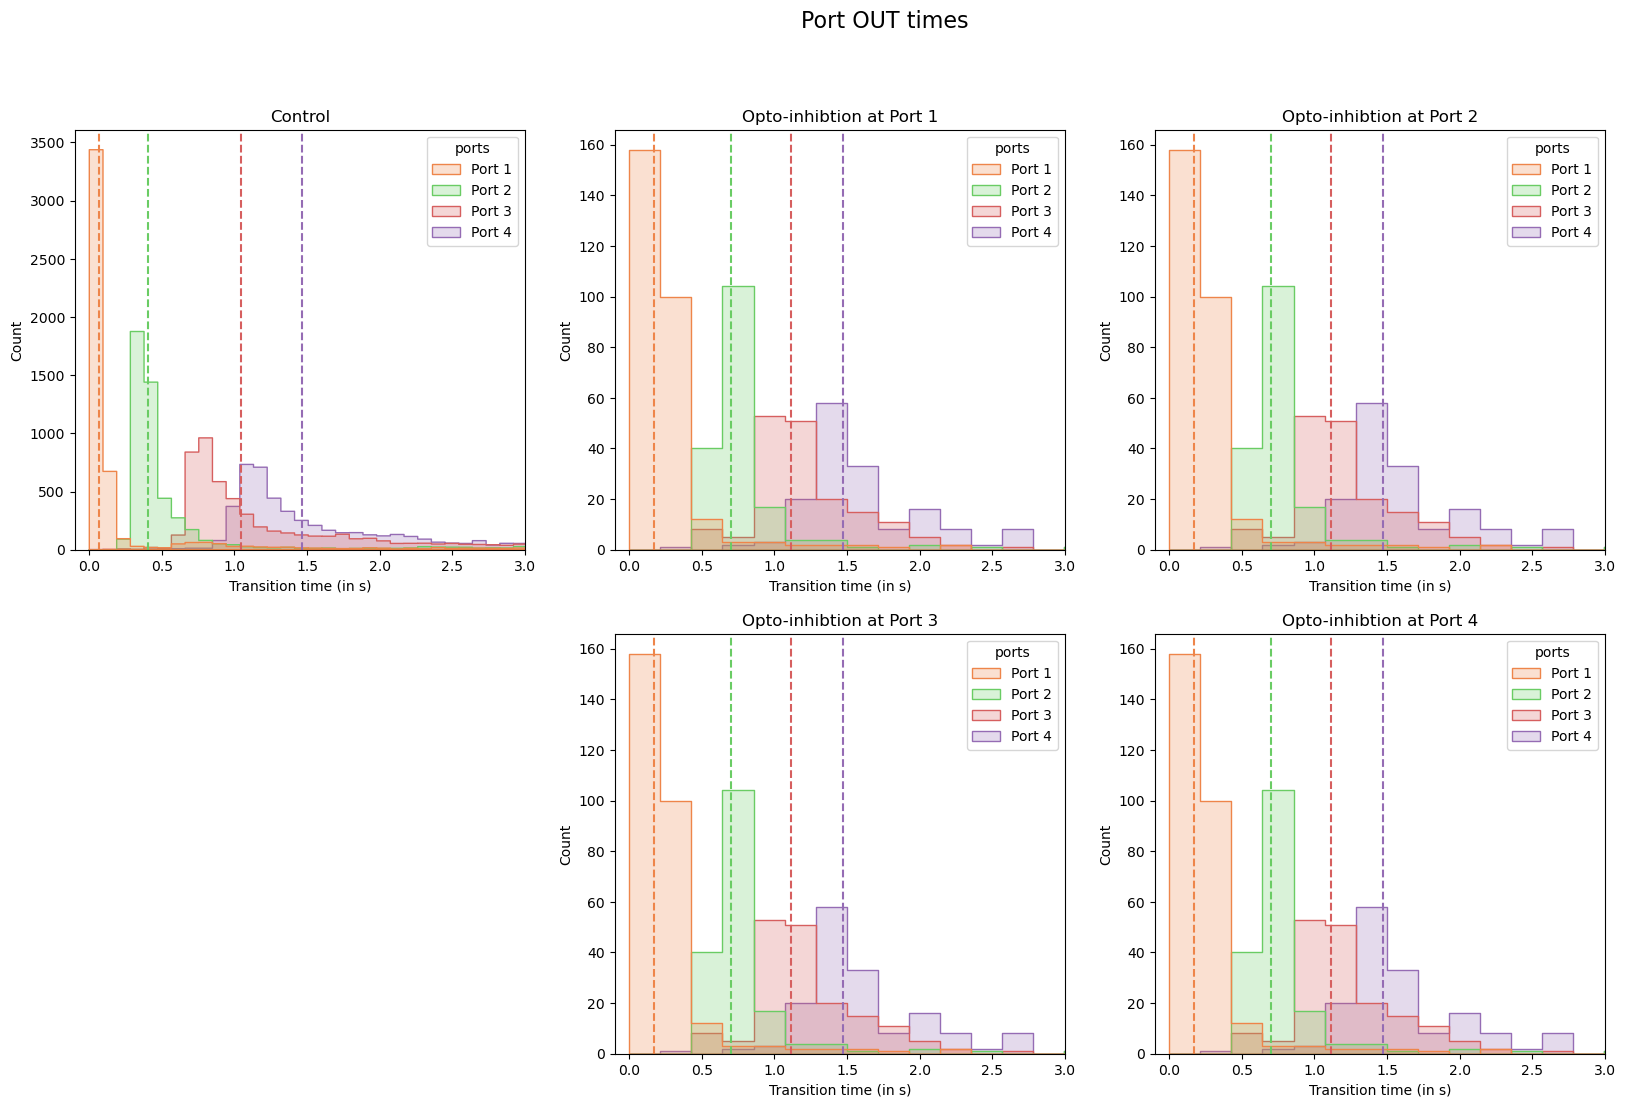

In [378]:
# fetch all opto data

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_distribution(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[0, 0])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[0, 1])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax= axs[0, 2])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[1, 1])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# set optional titles
axs[0, 0].set_title('Control')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.05) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port OUT times", fontsize=16)
plt.show()

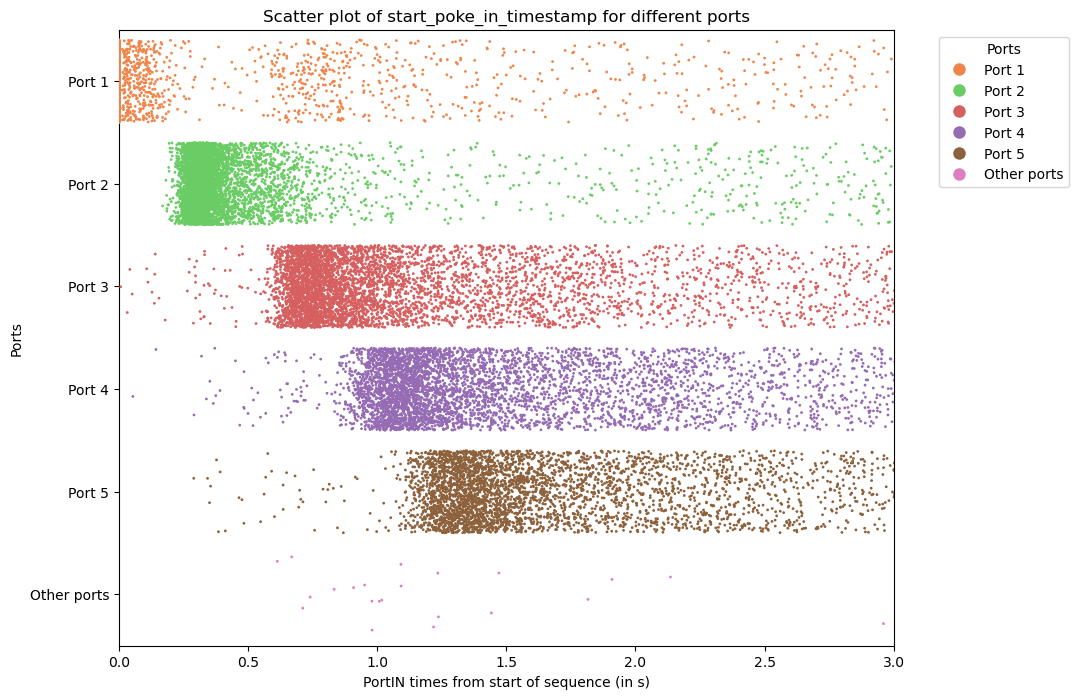

In [391]:
def plot_timestamp_strip(df, timestamps, x_range=(0, 5), exclude_ports=[], ax=None):
    """
    This function plots a scatter plot of timestamps for different ports.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains timestamps and port information.
    timestamps (str): The column name in df for the timestamp data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    ax (matplotlib.axes.Axes): Axes object to draw the plot onto.
    """

    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels = {2: 'Port 1', 1: 'Port 2',
                           6: 'Port 3', 3: 'Port 4',
                           7: 'Port 5', 4: 'Other ports',
                           5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, timestamps)):
            if port in port_labels.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[timestamps, 'ports'])

    # If no Axes object provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Use a color palette
    full_palette = sns.color_palette("muted", 10)
    palette_colors = full_palette[1:] # start from the third color

    # Generate a color dictionary based on the order of unique ports in the data
    color_dict = {port: palette_colors[i % len(palette_colors)] for i, port in enumerate(latency_df['ports'].unique())}

    # Plot the scatter plot of timestamps for each ports
    strip_plot = sns.stripplot(x=timestamps, y='ports', data=latency_df, size=2, jitter=0.4, palette=color_dict, hue='ports', ax=ax)

    # Set the limits of x-axis to 'zoom' in
    ax.set_xlim(x_range) 

    # Set the title and labels
    ax.set_title(f'Scatter plot of {timestamps} for different ports')
    ax.set_xlabel('Transition time (in s)')
    ax.set_ylabel('Ports')

    # Create legend with color patches
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=port,
                              markerfacecolor=color_dict[port], markersize=10) for port in latency_df['ports'].unique()]

    # Add legend to the plot
    ax.legend(handles=legend_elements, title="Ports", bbox_to_anchor=(1.05, 1), loc='upper left')

    return ax

ax = plot_timestamp_strip(filtered_control_df, 'start_poke_in_timestamp', x_range=(0,3), exclude_ports=[])
ax.set_xlabel('PortIN times from start of sequence (in s)')
plt.show()

### strip plot for port_in_times

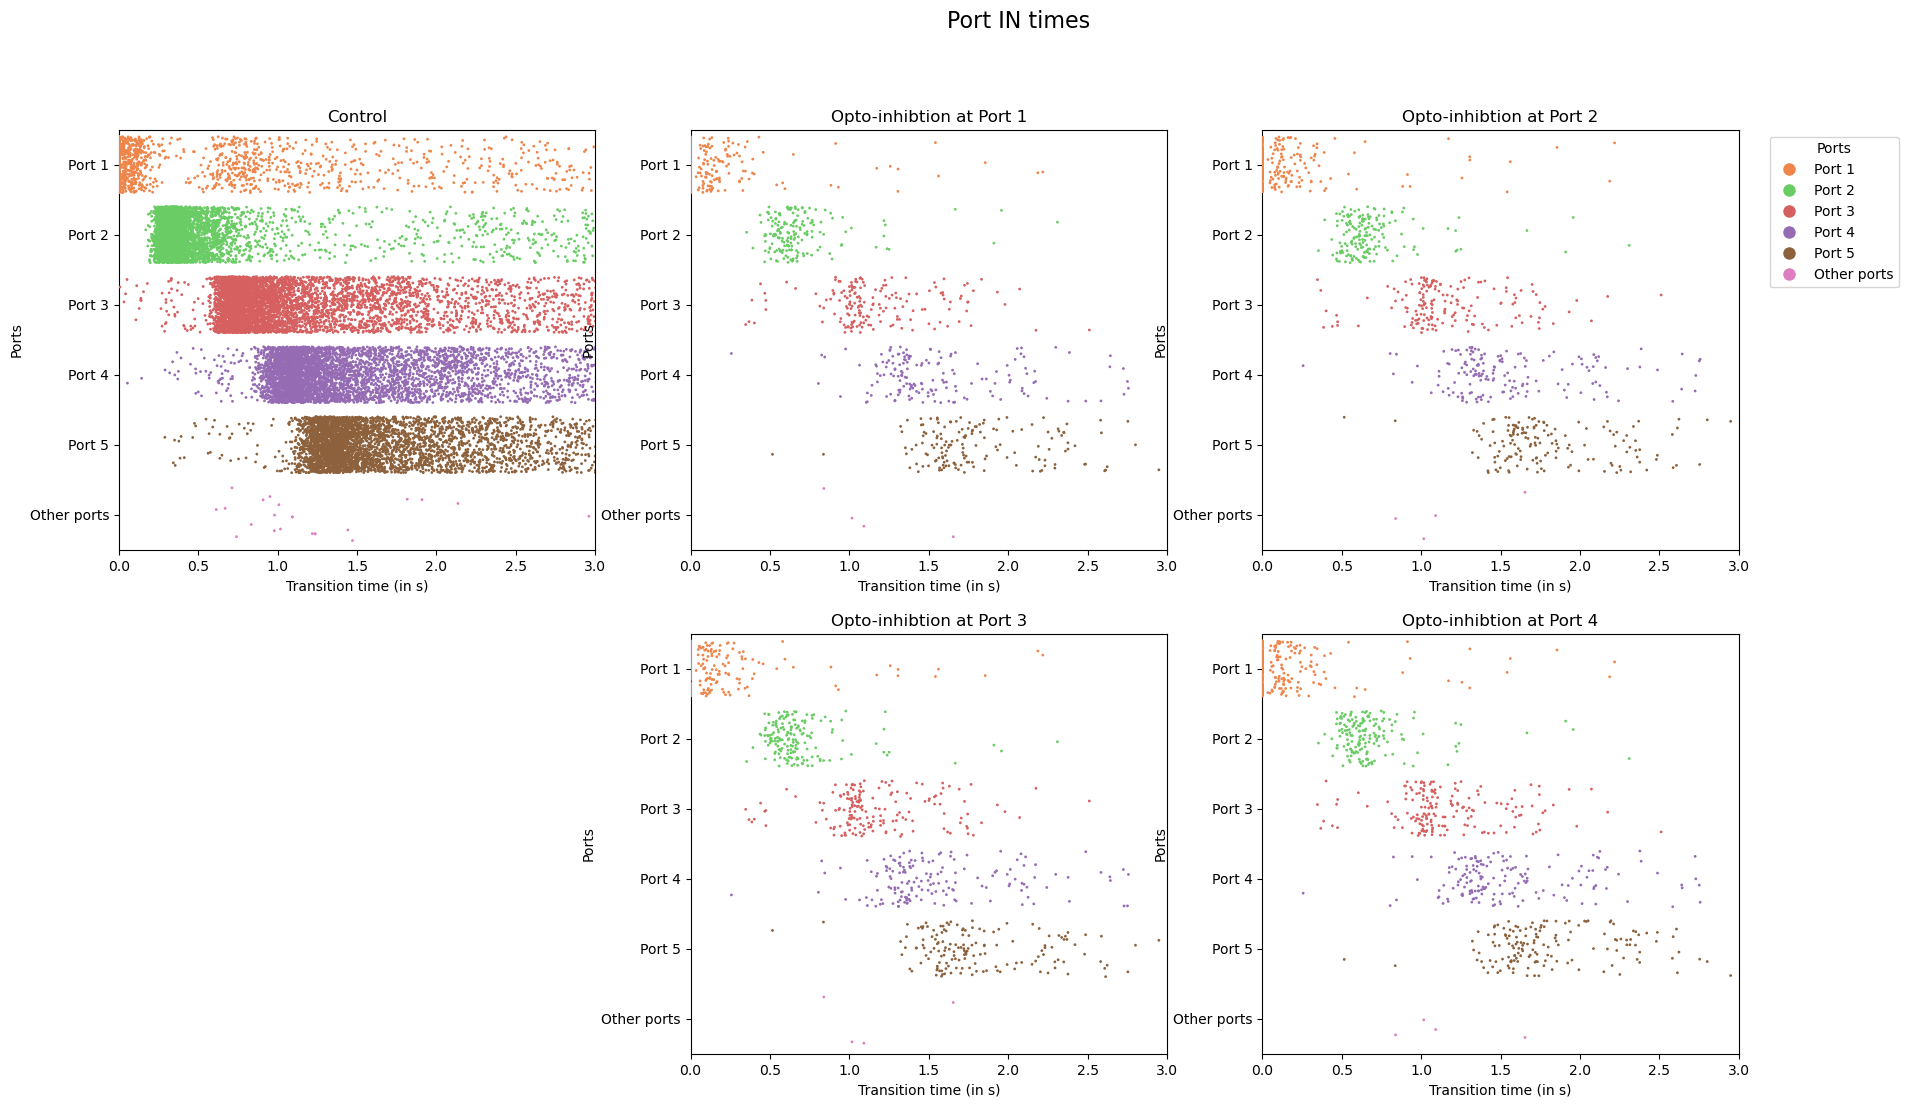

In [393]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_strip(filtered_control_df, 'start_poke_in_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[0, 0])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[0, 1])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(0,3), exclude_ports=[], ax= axs[0, 2])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[1, 1])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# switch off unneeded legends
axs[0, 0].legend_.remove()
axs[0, 1].legend_.remove()
axs[1, 1].legend_.remove()
axs[1, 2].legend_.remove()

# set optional titles
axs[0, 0].set_title('Control')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port IN times", fontsize=16)
plt.show()

### strip plot for port_out_times

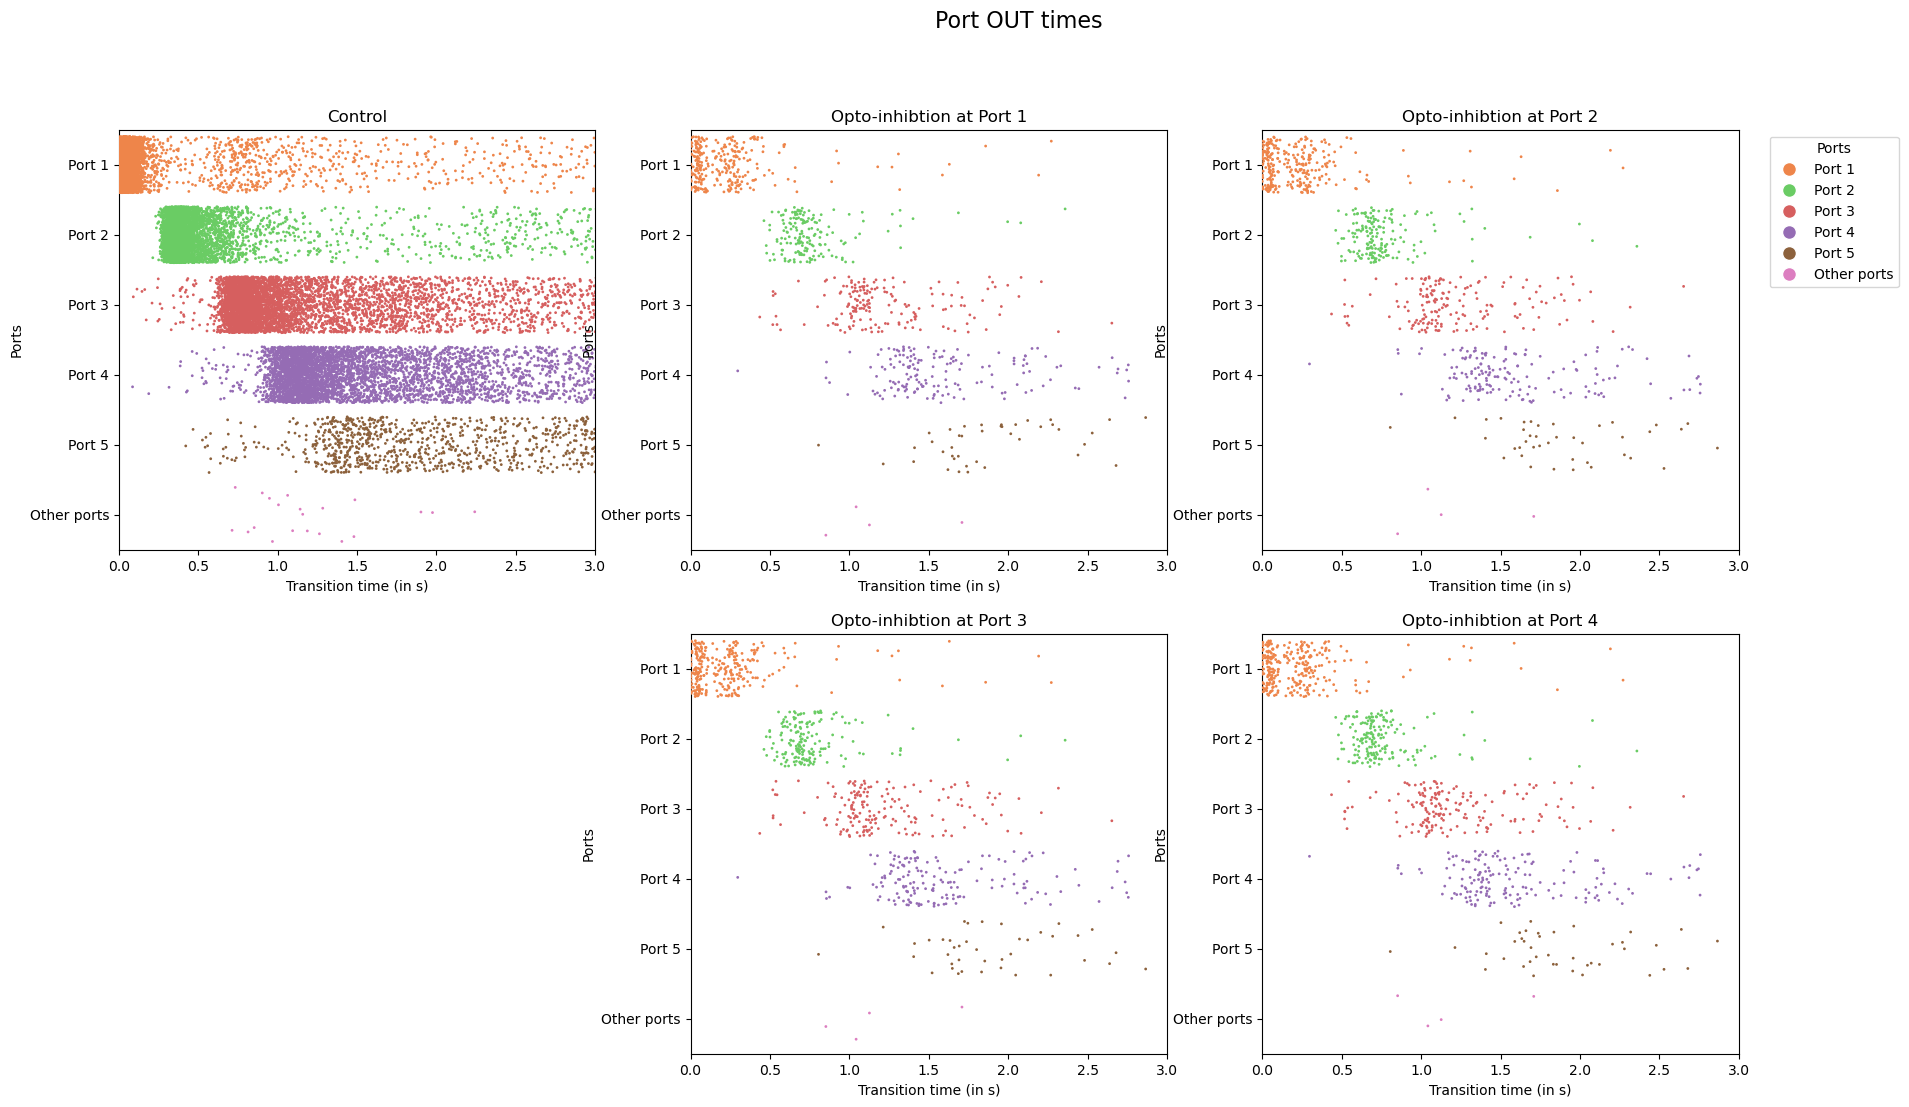

In [392]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_strip(filtered_control_df, 'start_poke_out_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[0, 0])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[0, 1])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(0,3), exclude_ports=[], ax= axs[0, 2])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[1, 1])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(0,3), exclude_ports=[], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# switch off unneeded legends
axs[0, 0].legend_.remove()
axs[0, 1].legend_.remove()
axs[1, 1].legend_.remove()
axs[1, 2].legend_.remove()

# set optional titles
axs[0, 0].set_title('Control')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port OUT times", fontsize=16)
plt.show()

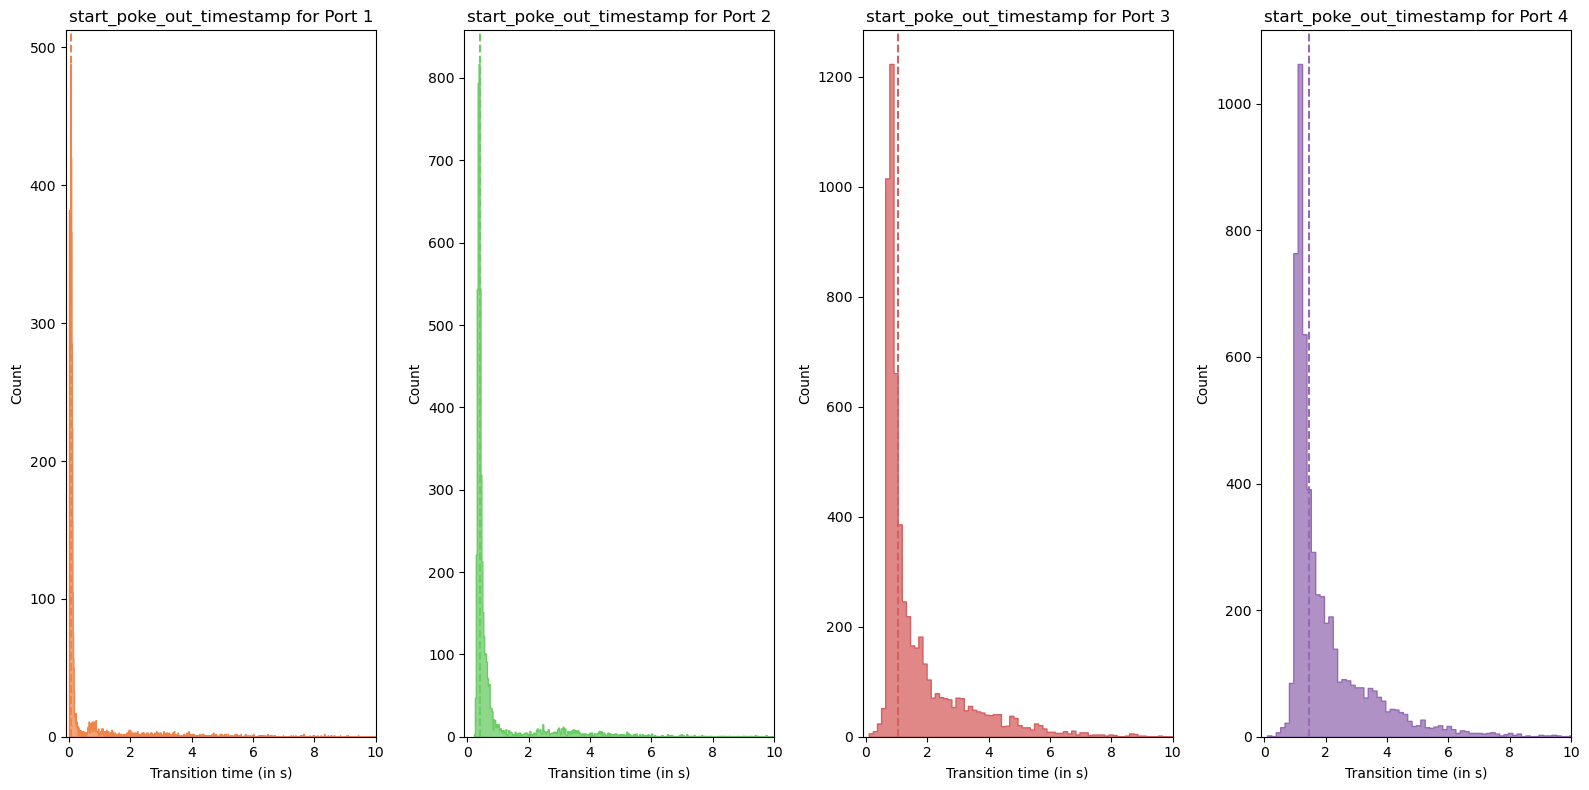

In [475]:
def plot_timestamp_distribution_subplots(df, timestamps, x_range=(0, 5), exclude_ports=[], fig_size=(15, 8), axes=None):
    """
    This function plots the distribution of timestamps for different ports on separate subplots.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains timestamps and port information.
    timestamps (str): The column name in df for the timestamp data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    fig_size (tuple): The size of the entire figure containing all subplots.
    """
    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels = {2: 'Port 1', 1: 'Port 2',
                   6: 'Port 3', 3: 'Port 4',
                   7: 'Port 5', 4: 'Other ports',
                   5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, timestamps)):
            if port in port_labels.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[timestamps, 'ports'])

    # Define a list of all possible ports
    possible_ports = ['Port 1', 'Port 2', 'Port 3', 'Port 4', 'Other ports']

    # Create a list of the ports in your data
    data_ports = latency_df['ports'].unique()

    # Create a new ordered_ports list that only includes ports in possible_ports that are also in your data
    ordered_ports = [port for port in possible_ports if port in data_ports]

    if axes is None:
        # Create a figure to hold the subplots
        fig, axes = plt.subplots(nrows=1, ncols=max(1, len(ordered_ports)), figsize=fig_size, sharex=True)
        if len(ordered_ports) == 1:
            axes = np.array([axes])  # Make sure axes is an array to handle single plot scenario

    # Use a color palette
    full_palette = sns.color_palette("muted", len(ordered_ports) + 1)  # Added 1 for starting from the second color
    palette_colors = full_palette[1:] 

    # Plot the distribution of timestamps for each port on a separate subplot
    for i, port in enumerate(ordered_ports):
        port_df = latency_df[latency_df['ports'] == port]
        ax = axes[i]
        sns.histplot(port_df, x=timestamps, color=palette_colors[i], element="step", stat='count', common_norm=False, ax=ax)

        # Set the title and labels
        ax.set_title(f'{timestamps} for {port}')
        ax.set_xlabel('Transition time (in s)')
        ax.set_ylabel('Count')

        # Set the limits of x-axis to 'zoom' in
        ax.set_xlim(x_range)

        # Add a vertical line at the median value of the distribution
        median_latency = port_df[timestamps].median()
        ax.axvline(median_latency, linestyle='--', color=palette_colors[i])

    # Reduce the vertical space between subplots
    plt.tight_layout()

    return ax.figure, axes



fig, axes = plot_timestamp_distribution_subplots(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,10), exclude_ports=[7, 4, 5, 8], fig_size=(16, 8))
plt.show()


### plot_timestamp_distribution_subplots port_in_times

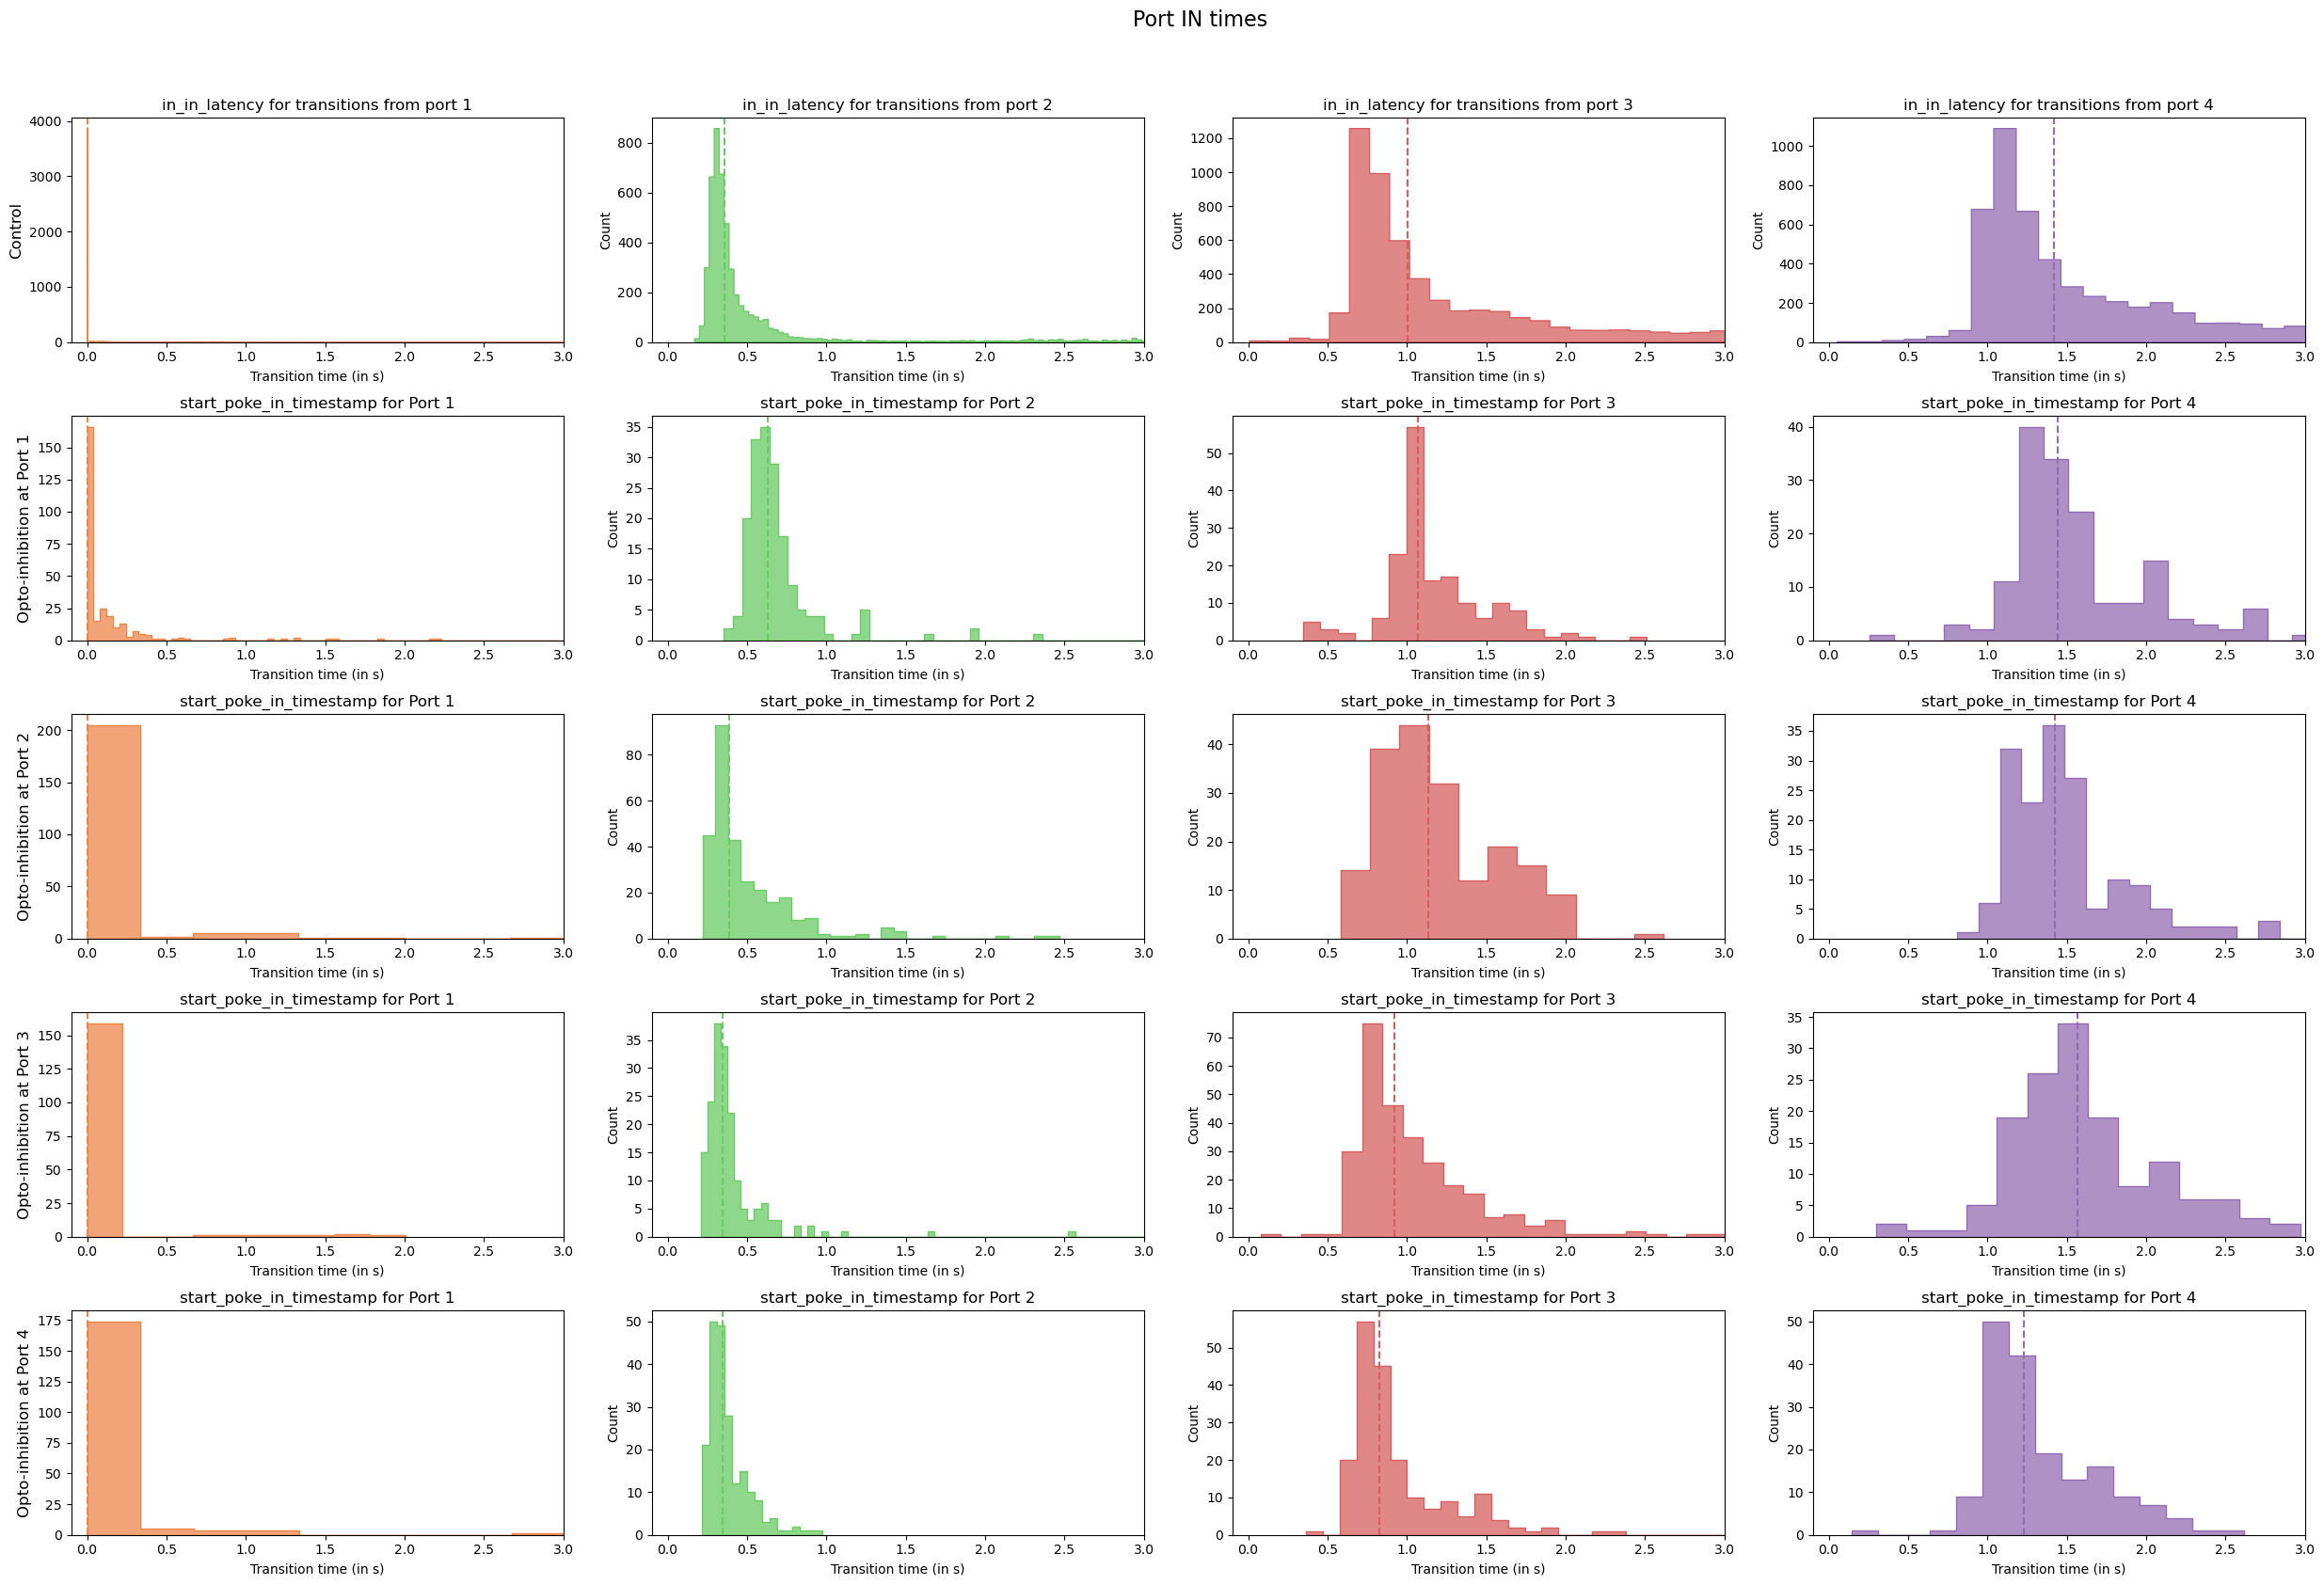

In [480]:
fig, axs = plt.subplots(5, 4, figsize=(24, 16))

plot_timestamp_distribution_subplots(filtered_control_df, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[0, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[1, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_2, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes= axs[2, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_3, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[3, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_4, 'start_poke_in_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[4, :])

# set optional titles
# Define row and column labels
row_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['in_in_latency for transitions from port 1', 'in_in_latency for transitions from port 2', 'in_in_latency for transitions from port 3', 'in_in_latency for transitions from port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port IN times", fontsize=16, y=1.05)
plt.show()

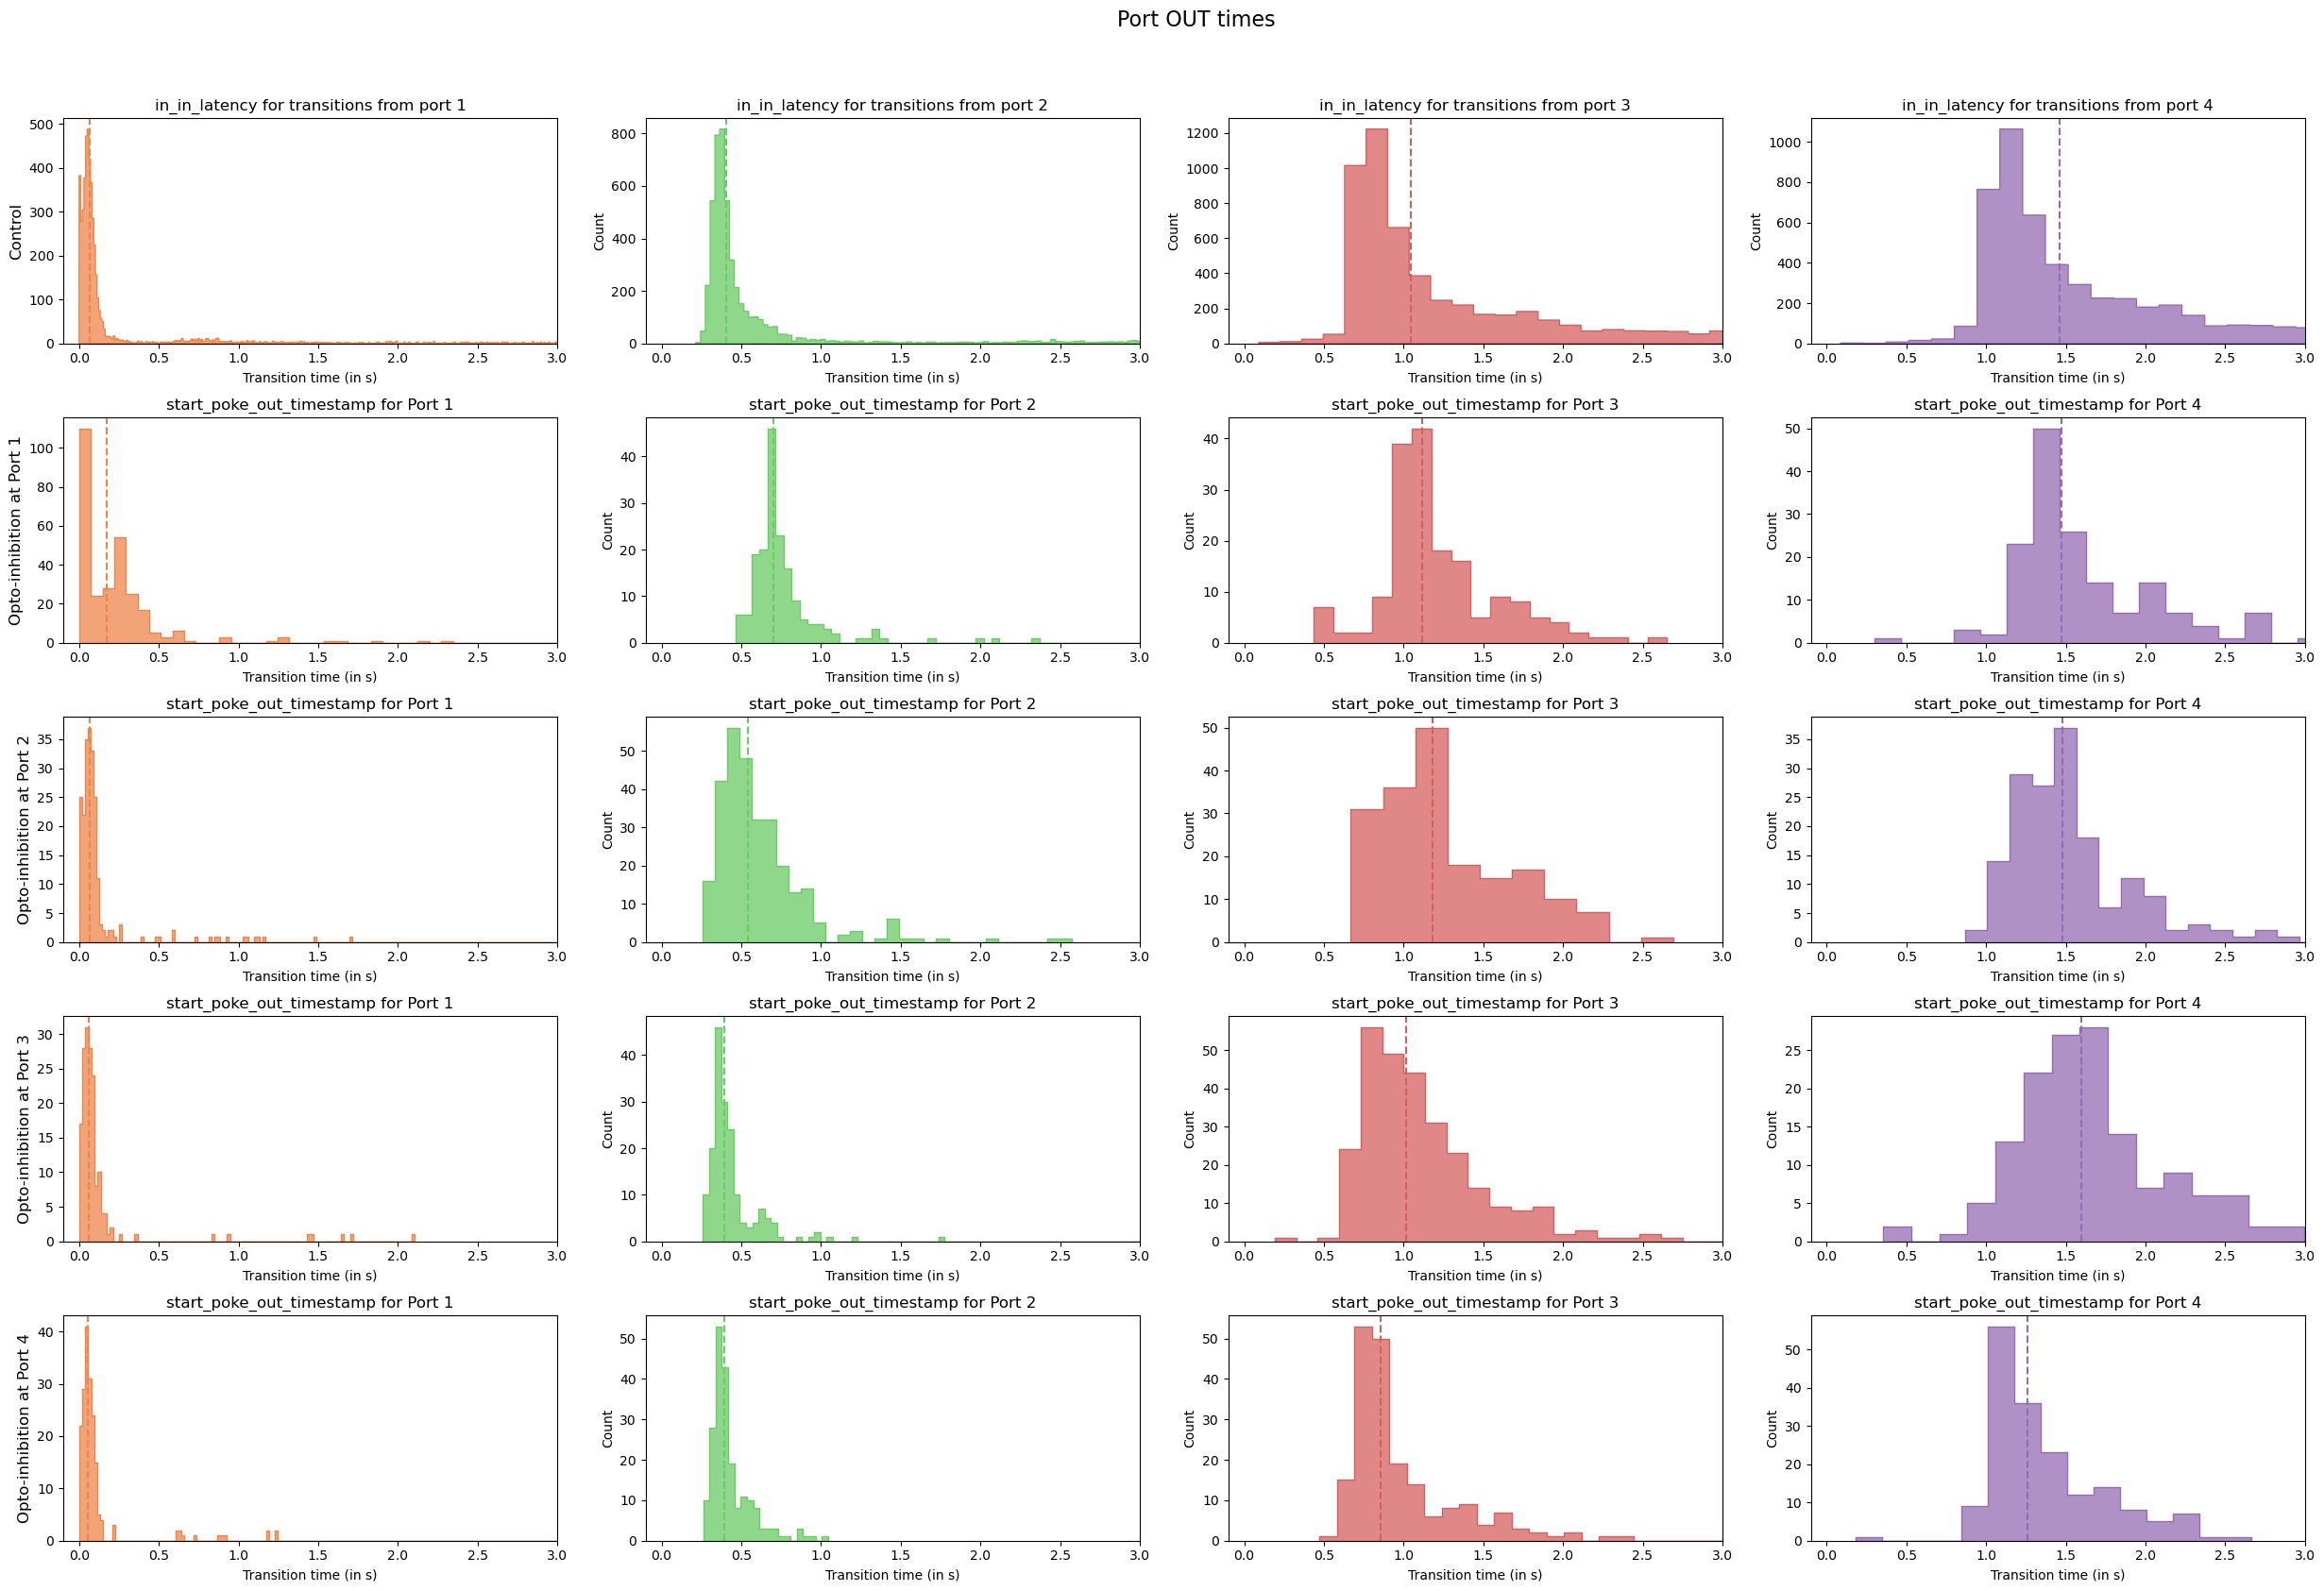

In [481]:
fig, axs = plt.subplots(5, 4, figsize=(24, 16))

plot_timestamp_distribution_subplots(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[0, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[1, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_2, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes= axs[2, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_3, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[3, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_4, 'start_poke_out_timestamp', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[4, :])

# set optional titles
# Define row and column labels
row_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['in_in_latency for transitions from port 1', 'in_in_latency for transitions from port 2', 'in_in_latency for transitions from port 3', 'in_in_latency for transitions from port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port OUT times", fontsize=16, y=1.05)
plt.show()

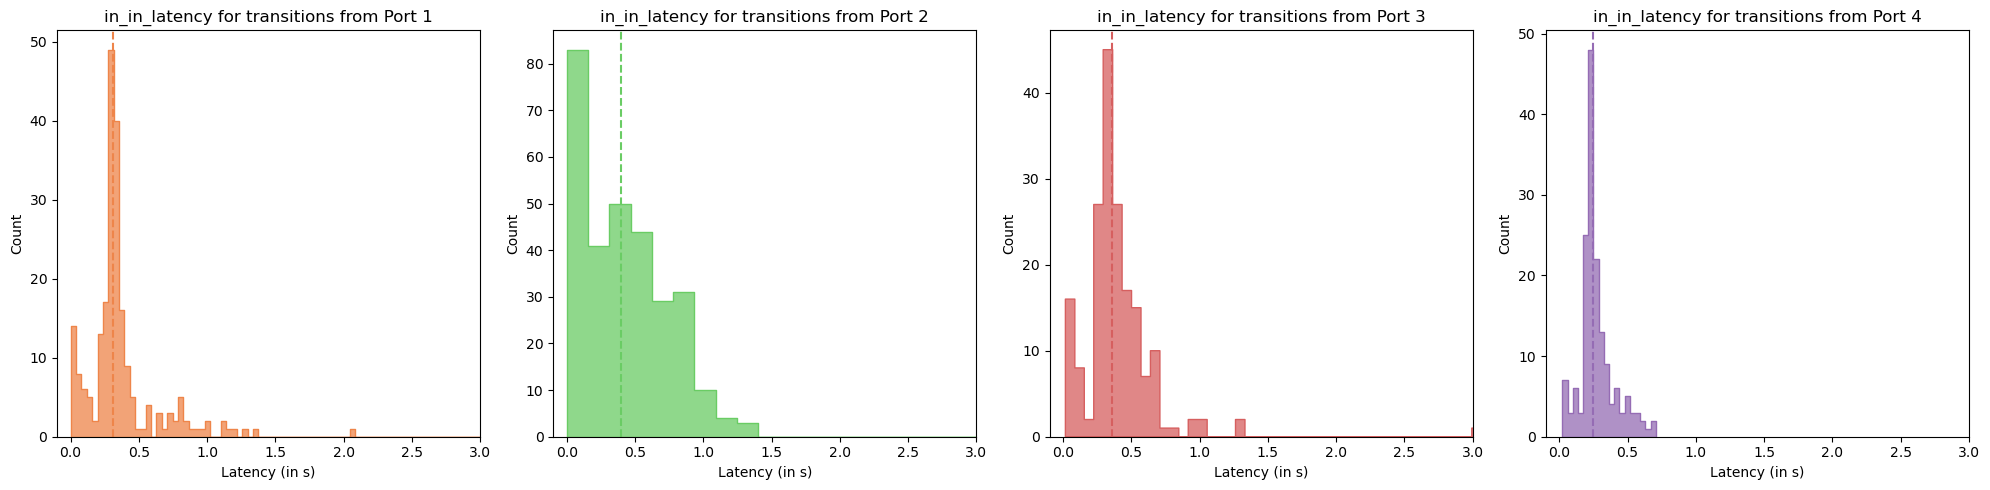

In [486]:
def plot_latency_distribution_subplots(df, latencies, x_range=(0, 5), exclude_ports=[], fig_size=(20, 5), axes=None):
    """
    This function plots the distribution of latencies for different ports on separate subplots.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains latencies and port information.
    latencies (str): The column name in df for the latency data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    fig_size (tuple): The size of the entire figure containing all subplots.
    axes (list of matplotlib.axes.Axes or matplotlib.axes.Axes): List of Axes objects where the plots will be drawn or a single Axes object.
    """
    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels_offsets = {2: 'Port 1', 1: 'Port 2',
                           6: 'Port 3', 3: 'Port 4',
                           7: 'Port 5', 4: 'Other ports',
                           5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, latencies)):
            if port in port_labels_offsets.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels_offsets[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[latencies, 'ports'])

    # Define a list of all possible ports
    possible_ports = ['Port 1', 'Port 2', 'Port 3', 'Port 4', 'Other ports']

    # Create a list of the ports in your data
    data_ports = latency_df['ports'].unique()

    # Create a new ordered_ports list that only includes ports in possible_ports that are also in your data
    ordered_ports = [port for port in possible_ports if port in data_ports]

    # Create a figure to hold the subplots
    if axes is None:
        fig, axes = plt.subplots(nrows=1, ncols=max(1, len(ordered_ports)), figsize=fig_size, sharex=True)
        if len(ordered_ports) == 1:
            axes = np.array([axes])  # Make sure axes is an array to handle single plot scenario

    # Use a color palette
    full_palette = sns.color_palette("muted", len(latency_df['ports'].unique()) + 1)  # Added 1 for starting from the second color
    palette_colors = full_palette[1:] 

    # Plot the distribution of latencies for each port on a separate subplot
    for i, port in enumerate(ordered_ports):
        port_df = latency_df[latency_df['ports'] == port]
        ax = axes[i]
        sns.histplot(port_df, x=latencies, color=palette_colors[i], element="step", stat='count', common_norm=False, ax=ax)

        # Set the title and labels
        ax.set_title(f'{latencies} for transitions from {port}')
        ax.set_xlabel('Latency (in s)')
        ax.set_ylabel('Count')

        # Set the limits of x-axis to 'zoom' in
        ax.set_xlim(x_range)

        # Add a vertical line at the median value of the distribution
        median_latency = port_df[latencies].median()
        ax.axvline(median_latency, linestyle='--', color=palette_colors[i])

    # Reduce the vertical space between subplots
    plt.tight_layout()

    return ax.figure, axes



fig, axes = plot_latency_distribution_subplots(filtered_optostim_port_2, 'in_in_latency', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(20, 5))
plt.show()


### plot_latency_distribution_subplots for in_in_latency

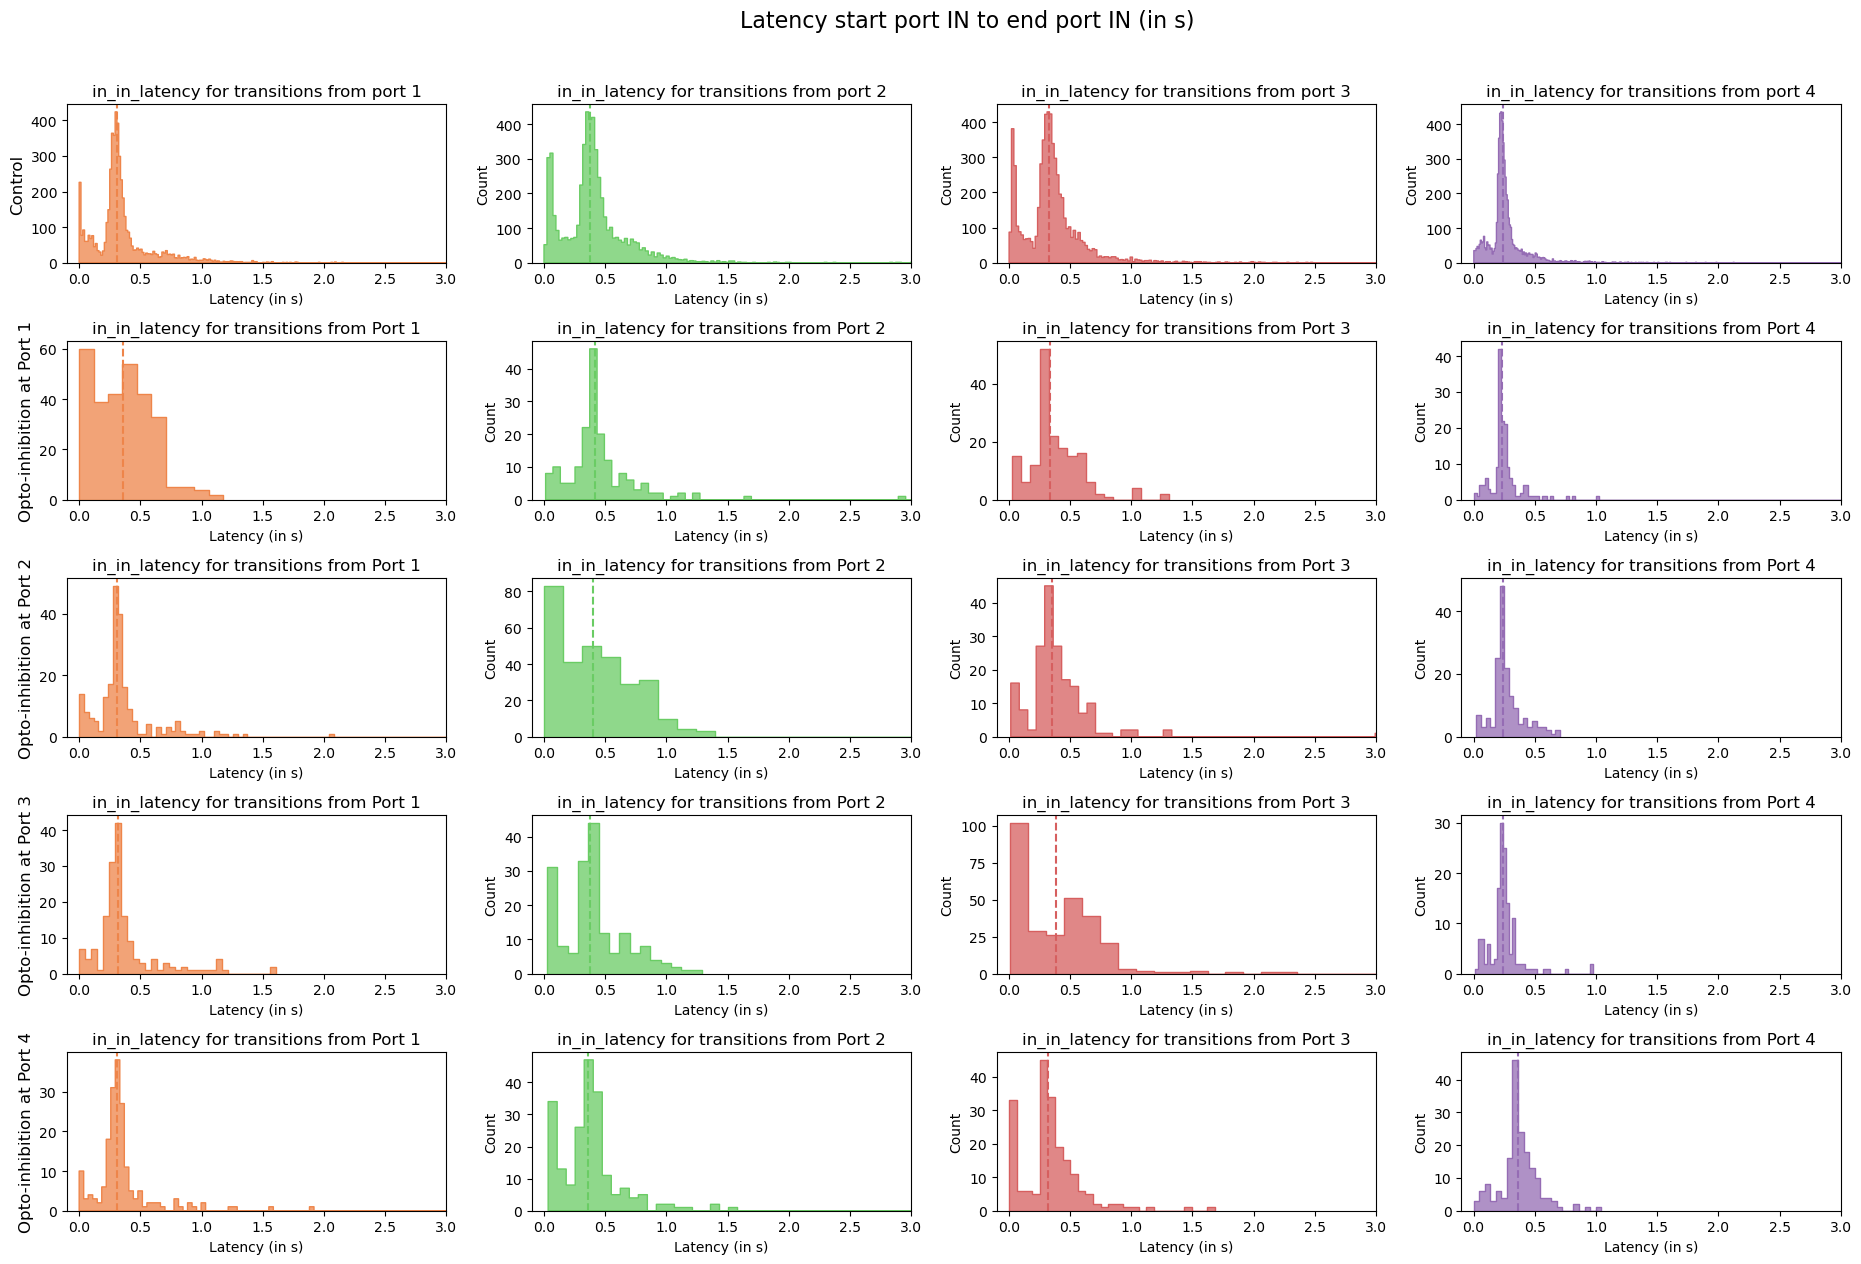

In [469]:
fig, axs = plt.subplots(5, 4, figsize=(18, 12))

plot_latency_distribution_subplots(filtered_control_df, 'in_in_latency', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[0, :])
plot_latency_distribution_subplots(filtered_optostim_port_1, 'in_in_latency', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[1, :])
plot_latency_distribution_subplots(filtered_optostim_port_2, 'in_in_latency', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes= axs[2, :])
plot_latency_distribution_subplots(filtered_optostim_port_3, 'in_in_latency', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[3, :])
plot_latency_distribution_subplots(filtered_optostim_port_4, 'in_in_latency', x_range=(-0.1,3), exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[4, :])

# You can hide the unused subplot with this line
# axs[1, 0].axis('off')

# Define row and column labels
row_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['in_in_latency for transitions from port 1', 'in_in_latency for transitions from port 2', 'in_in_latency for transitions from port 3', 'in_in_latency for transitions from port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Latency start port IN to end port IN (in s)", fontsize=16, y = 1.05)
plt.show()

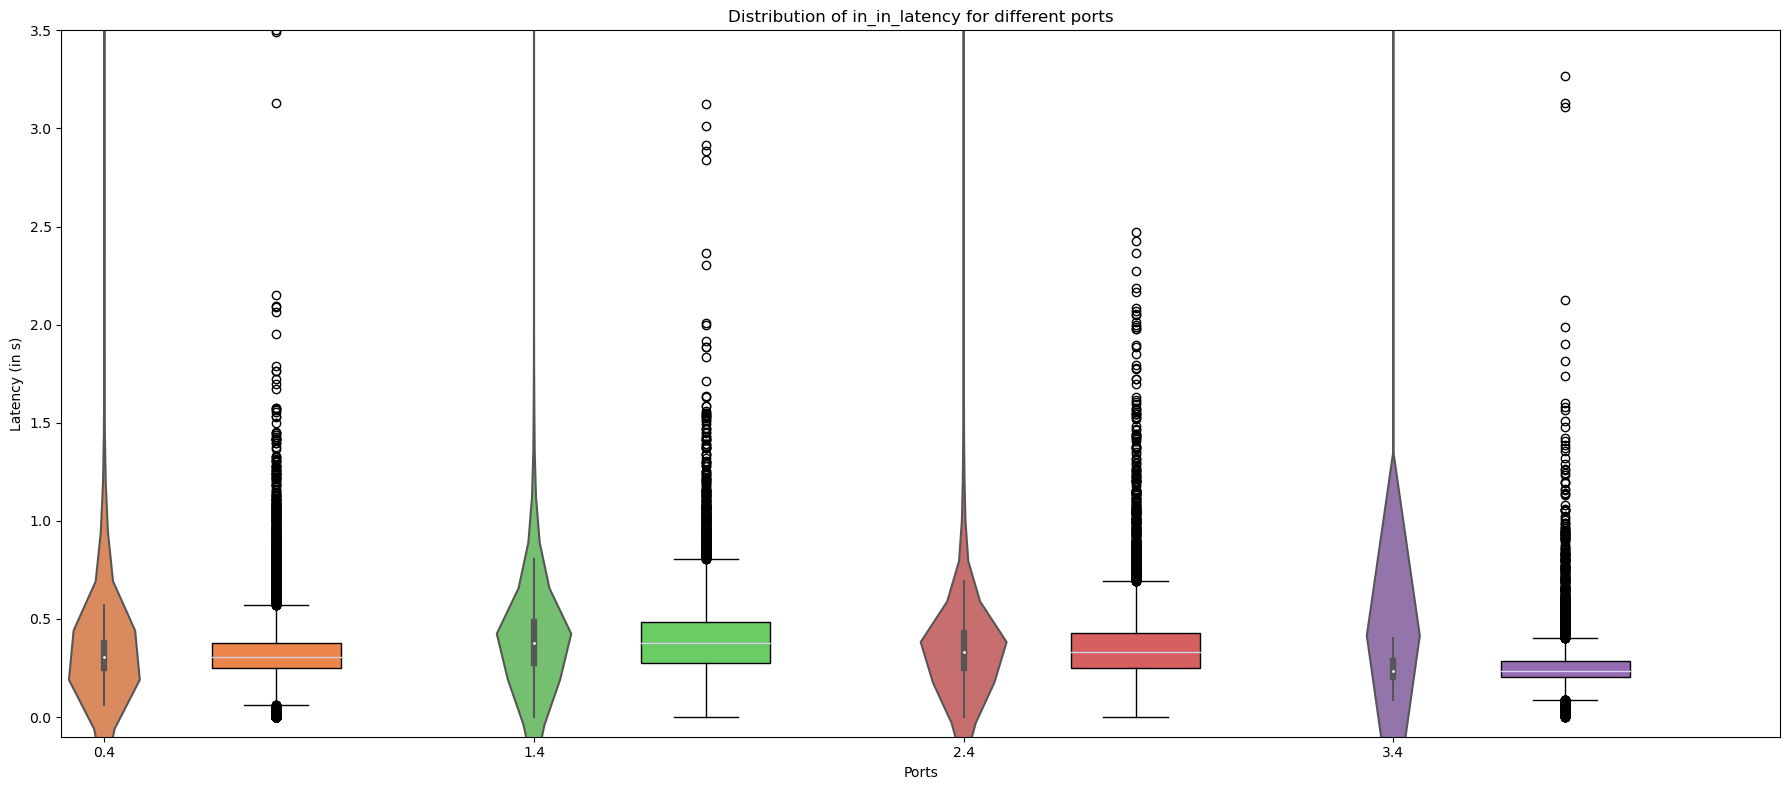

In [470]:
def plot_latency_statistics(df, latencies, y_range=(0, 5), exclude_ports=[], fig_size=(18, 8), offset_value=0.3):
    """
    This function plots the distribution of latencies for different ports on the same plot, creating both a boxplot and a violinplot side by side with offset for better visualization.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains latencies and port information.
    latencies (str): The column name in df for the latency data to plot.
    y_range (tuple): The range of y values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    fig_size (tuple): The size of the entire figure.
    offset_value (float): The amount of offset between boxplot and violin plot.
    """
    latency_data = []
    port_labels_offsets = {2: 'Port 1', 1: 'Port 2',
                           6: 'Port 3', 3: 'Port 4',
                           7: 'Port 5', 4: 'Other ports',
                           5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, latencies)):
            if port in port_labels_offsets.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels_offsets[port]))

    latency_df = pd.DataFrame(latency_data, columns=[latencies, 'ports'])

    fig, ax = plt.subplots(figsize=fig_size)

    full_palette = sns.color_palette("muted", len(latency_df['ports'].unique()) + 1)
    palette_colors = dict(zip(latency_df['ports'].unique(), full_palette[1:]))

    pos = range(len(latency_df['ports'].unique()))
    offset = [i+offset_value for i in pos]  # Offset for boxplot
    offset_violin = [i-offset_value for i in pos]  # Offset for violinplot

    boxplot_data = [latency_df[latency_df['ports'] == port][latencies] for port in latency_df['ports'].unique()]
    
    # Plot a violinplot
    sns.violinplot(data=latency_df, x='ports', y=latencies, palette=palette_colors, ax=ax, positions=offset_violin, width=0.2)

    # Plot a boxplot
    bp = ax.boxplot(boxplot_data, positions=offset, widths=0.3, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], full_palette[1:]):
        patch.set_facecolor(color)

    ax.set_title(f'Distribution of {latencies} for different ports')
    ax.set_xlabel('Ports')
    ax.set_ylabel('Latency (in s)')
    ax.set_ylim(y_range)
    ax.set_xticks(pos)

    plt.tight_layout()

    return fig, ax

fig, ax = plot_latency_statistics(filtered_control_df, 'in_in_latency', y_range=(-0.1,3.5), exclude_ports=[7, 4, 5, 8], fig_size=(18, 8), offset_value=0.4)
plt.show()


In [487]:
# do some basic calculations
# length of the sequence

def get_lengths_for_unique_trials(df, column_name):
    # Get all unique cumulative_trial_ids and sort them
    unique_trial_ids = df['cumulative_trial_id'].unique()
    unique_trial_ids.sort()

    # Create an empty list to store the lengths of column_name for each unique trial ID
    lengths = []

    # Loop through the unique_trial_ids
    for trial_id in unique_trial_ids:
        # Filter the DataFrame for the current trial_id
        trial_df = df[df['cumulative_trial_id'] == trial_id]

        # Get the length of the column_name for the current trial_id and append it to the lengths list
        length = len(trial_df[column_name].iloc[0])
        lengths.append(length)

    return lengths

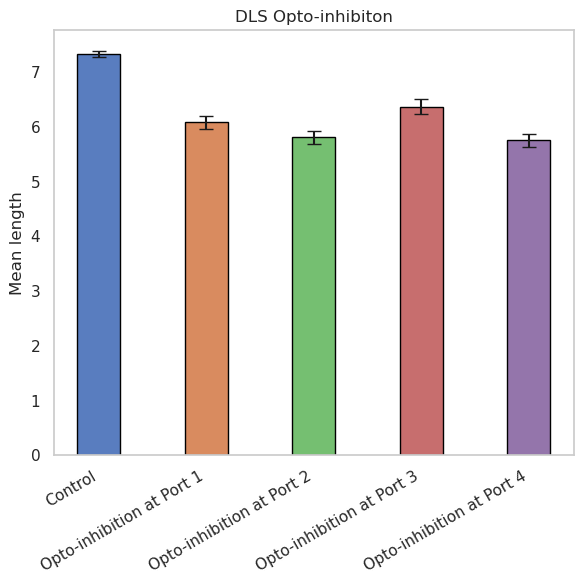

T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: 4.743000424319101
P-Value: 2.1824570267817594e-06
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: 6.0844922048211405
P-Value: 1.2827758110573297e-09
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: 3.499930899992491
P-Value: 0.00047070036677767545
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 6.071108725220734
P-Value: 1.3937609500865444e-09
Result: Significant difference



In [528]:
# List of DataFrames
dataframes_list = [filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]

# Column name to analyze (e.g., 'start_poke_port')
column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

# Create a dictionary to store statistics for each DataFrame
statistics_dict = {}

# List to store the data samples for t-tests
data_samples = []

# Loop through the list of DataFrames
for index, df in enumerate(dataframes_list):
    # Get the lengths for the current DataFrame and column_name
    lengths_list = get_lengths_for_unique_trials(df, column_name)

    # Calculate basic statistics
    stats = {
        'mean': sum(lengths_list) / len(lengths_list),
        'std': pd.Series(lengths_list).std(),
        'sem': pd.Series(lengths_list).sem()
    }

    statistics_dict[data_labels[index]] = stats

    # Append the lengths_list to data_samples for t-tests
    data_samples.append(lengths_list)

# Perform t-tests between Control and other groups
control_data = data_samples[0]
t_test_results = {}
for i, group_data in enumerate(data_samples[1:], start=1):
    t_stat, p_value = ttest_ind(control_data, group_data)
    t_test_results[data_labels[i]] = {'T-Statistic': t_stat, 'P-Value': p_value, 'Significant': p_value < 0.05}

# Create a DataFrame from the statistics dictionary for easier plotting
statistics_df = pd.DataFrame(statistics_dict).transpose()

# Plotting (Same as before)
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=data_labels, y='mean', data=statistics_df, palette="muted", errwidth=1.5, edgecolor='black', width=0.4)

# Add error bars with S.D.
# ax.errorbar(range(len(statistics_df)), statistics_df['mean'], yerr=statistics_df['std'], fmt='none', c='k', capsize=5)

# Add error bars with SEM
ax.errorbar(range(len(statistics_df)), statistics_df['mean'], yerr=statistics_df['sem'], fmt='none', c='k', capsize=5)

ax.set_ylabel('Mean length')
plt.xticks(rotation=30, ha='right', va='top')
plt.title(f'DLS Opto-inhibiton')
plt.grid(False)
plt.tight_layout()
plt.show()

# Print t-test results
for group, result in t_test_results.items():
    print(f"T-Test: Control vs {group}")
    print(f"T-Statistic: {result['T-Statistic']}")
    print(f"P-Value: {result['P-Value']}")
    if result['Significant']:
        print("Result: Significant difference\n")
    else:
        print("Result: No significant difference\n")

In [519]:
def compute_truncation_probability(test_sequence, perfect_sequence, allow_repeats=True):
    total_started_sequences = 0
    total_truncated_sequences = 0
    next_expected_index = 0
    truncation_count = {key: 0 for key in perfect_sequence}  # Initialize dictionary to store truncation counts
    
    for poke in test_sequence:
        if poke == perfect_sequence[next_expected_index]:  # Check if the current poke matches the next expected poke
            total_started_sequences += 1 if next_expected_index == 0 else total_started_sequences
            next_expected_index += 1
            if next_expected_index >= len(perfect_sequence):
                next_expected_index = 0  # If we've reached the end of the perfect sequence, reset to the start
        else:
            # Check for repetition
            if allow_repeats and next_expected_index > 0 and poke == perfect_sequence[next_expected_index - 1]:
                continue
            else:
                if total_started_sequences > 0:
                    total_truncated_sequences += 1
                    truncation_count[perfect_sequence[next_expected_index - 1 if next_expected_index > 0 else 0]] += 1  # Increment count for the last expected poke
                next_expected_index = 0  # Reset to the start of the perfect sequence

    if total_started_sequences > 0:
        truncation_probability = total_truncated_sequences / total_started_sequences
    elif total_truncated_sequences == 0:
        truncation_probability = 0  # Return 0 if there are no truncations and at least one sequence has started
    else:
        truncation_probability = None  # No sequence started yet
    
    return truncation_probability, truncation_count


# Compute truncation probability and truncation counts
truncation_probability, truncation_counts = compute_truncation_probability(test_sequence, perfect_sequence, allow_repeats=True)

# Print the truncation probability and counts
print(f'Truncation probability: {truncation_probability}')
print('Truncation counts:', truncation_counts)

Truncation probability: 2.0
Truncation counts: {2: 3, 1: 1, 6: 0, 3: 0, 7: 0}


In [535]:
def get_truncation_probability(df, column_name, allow_repeats=False):
    # Get all unique cumulative_trial_ids and sort them
    unique_trial_ids = df['cumulative_trial_id'].unique()
    unique_trial_ids.sort()

    # Create empty lists to store the lengths of column_name for each unique trial ID
    truncation_probabilities = []
    truncation_counts = []

    # Loop through the unique_trial_ids
    for trial_id in unique_trial_ids:
        # Filter the DataFrame for the current trial_id
        trial_df = df[df['cumulative_trial_id'] == trial_id]
        # Get truncation probability from the compute_truncation_probability function
        test_sequence = trial_df[column_name].iloc[0]
        truncation_probability, truncation_count = compute_truncation_probability(test_sequence, perfect_sequence=[2, 1, 6, 3, 7], allow_repeats=allow_repeats)
        truncation_probabilities.append(truncation_probability)
        truncation_counts.append(truncation_count)

    return truncation_probabilities, truncation_counts


# Compute truncation probability and truncation counts
truncation_probability, truncation_counts = get_truncation_probability(filtered_control_df, 'start_poke_port')

In [536]:
# print(truncation_probability)
# print(truncation_counts)

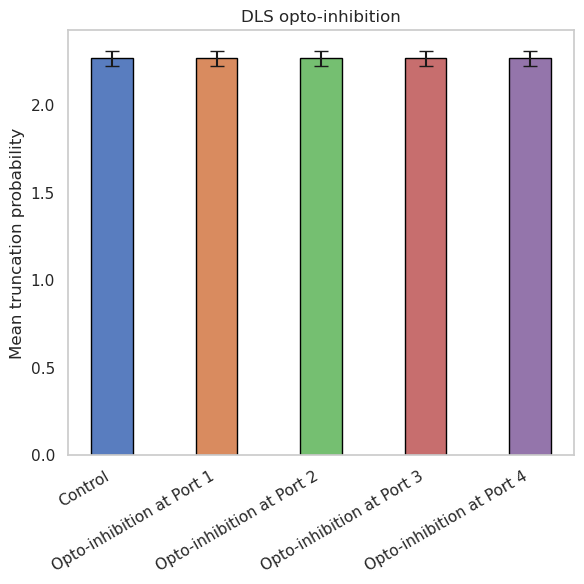

T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: 0.0
P-Value: 1.0
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: 0.0
P-Value: 1.0
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: 0.0
P-Value: 1.0
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 0.0
P-Value: 1.0
Result: No significant difference



In [537]:
## plot truncation probabilities
# List of DataFrames
dataframes_list = [filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]

# # Column name to analyze (e.g., 'start_poke_port')
# column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

# Create a dictionary to store statistics for each DataFrame
statistics_dict = {}

# List to store the data samples for t-tests
data_samples = []

# Loop through the list of DataFrames
for index, df in enumerate(dataframes_list):
    # Compute truncation probability and truncation counts
    truncation_probability, truncation_counts = get_truncation_probability(filtered_control_df, 'start_poke_port', allow_repeats=False)

    # Calculate basic statistics
    stats = {
        'mean': sum(truncation_probability) / len(truncation_probability),
        'std': pd.Series(truncation_probability).std(),
        'sem': pd.Series(truncation_probability).sem()
    }

    statistics_dict[data_labels[index]] = stats

    # Append the truncation_probability to data_samples for t-tests
    data_samples.append(truncation_probability)

# Perform t-tests between Control and other groups
control_data = data_samples[0]
t_test_results = {}
for i, group_data in enumerate(data_samples[1:], start=1):
    t_stat, p_value = ttest_ind(control_data, group_data)
    t_test_results[data_labels[i]] = {'T-Statistic': t_stat, 'P-Value': p_value, 'Significant': p_value < 0.05}

# Create a DataFrame from the statistics dictionary for easier plotting
statistics_df = pd.DataFrame(statistics_dict).transpose()

# Plotting (Same as before)
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=data_labels, y='mean', data=statistics_df, palette="muted", errwidth=1.5, edgecolor='black', width=0.4)

# Add error bars with S.D.
# ax.errorbar(range(len(statistics_df)), statistics_df['mean'], yerr=statistics_df['std'], fmt='none', c='k', capsize=5)

# Add error bars with SEM
ax.errorbar(range(len(statistics_df)), statistics_df['mean'], yerr=statistics_df['sem'], fmt='none', c='k', capsize=5)

ax.set_ylabel('Mean truncation probability')
plt.xticks(rotation=30, ha='right', va='top')
plt.title('DLS opto-inhibition')
plt.grid(False)
plt.tight_layout()
plt.show()

# Print t-test results
for group, result in t_test_results.items():
    print(f"T-Test: Control vs {group}")
    print(f"T-Statistic: {result['T-Statistic']}")
    print(f"P-Value: {result['P-Value']}")
    if result['Significant']:
        print("Result: Significant difference\n")
    else:
        print("Result: No significant difference\n")

In [540]:
## plot truncation counts
# List of DataFrames
dataframes_list = [filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]

# # Column name to analyze (e.g., 'start_poke_port')
# column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']


# List to store the data samples for t-tests
data_samples = []

# Loop through the list of DataFrames
for index, df in enumerate(dataframes_list):
    # Compute truncation probability and truncation counts
    truncation_probability, truncation_counts = get_truncation_probability(filtered_control_df, 'start_poke_port', allow_repeats=False)

# truncation count is a list of dictionaries with keys as port numbers and values as truncation_counts
# plot the truncation counts for each port
# convert truncation count to a dataframe for easy plotting

truncation_counts_df = pd.DataFrame(truncation_counts)

# Plotting (Same as before)
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=data_labels, y='truncation_counts', data=truncation_counts_df, palette="muted", errwidth=1.5, edgecolor='black', width=0.4)

# Add error bars with S.D.
# ax.errorbar(range(len(statistics_df)), statistics_df['mean'], yerr=statistics_df['std'], fmt='none', c='k', capsize=5)



ax.set_ylabel('Mean truncation probability')
plt.xticks(rotation=30, ha='right', va='top')
plt.title('DLS opto-inhibition')
plt.grid(False)
plt.tight_layout()
plt.show()



ValueError: Could not interpret input 'truncation_counts'

<Figure size 600x600 with 0 Axes>